In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import pickle
import numpy as np

from scipy.interpolate import RegularGridInterpolator
from scipy.stats import chi2
from scipy.special import erfinv, erf
from scipy.optimize import fmin_l_bfgs_b
from settings import LIVETIME, GAMMA_ASTRO, PHI_ASTRO, poles, E_NORM
from tools import get_mids
from aeff_calculations import energy_smearing

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


In [3]:
import warnings
import seaborn as sns
matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use("../style.mplstyle")
colorlist = plt.rcParams["axes.prop_cycle"].by_key()["color"]
warnings.filterwarnings("ignore")

In [4]:
print(LIVETIME)
print(GAMMA_ASTRO)
print(PHI_ASTRO)

315567360.0
2.37
1.44e-18


# Get the effective areas based on "alternative_plenum_aeff.ipynb"

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [5]:
# use only upgoing data to mimick up-going muon track data set
with open("../resources/tabulated_logE_sindec_aeff_upgoing.pckl", "rb") as f:
    logE_bins, sindec_bins, aeff_2d = pickle.load(f)

logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

ra_bins = np.linspace(0, np.pi * 2, num=101)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]
print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

40 log_10(energy) bins
50 declination bins


### here, we use "Plenum-1" with 10yr IceCube and 10yr PLENUM with IceCube
= baseline PLENUM + 10yr IceCube
### and "Plenum-2" with 10yr IceCube and 10yr PLENUM with GEN2
= baseline PLENUM (includes 10yr IceCube) + 10yr GEN2


### background

In [6]:
# MCEQ
with open("../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), 
    np.log(flux_def['numu_conv'])
)
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))

## Icecube energy x sindec
### comparison to diffuse (only northern) should yield ~600k events, ~2700 astro for a livetime of 10 years

In [7]:
from aeff_calculations import aeff_eval_e_sd
from settings import E_NORM

In [8]:
# check
for det in ["IceCube", "Plenum-1"]:
    aeff_factor = aeff_eval_e_sd(aeff_2d[det], sindec_width, ewidth, ra_width) * LIVETIME
    astro_ev = aeff_factor * (emids/E_NORM)**(-GAMMA_ASTRO) * PHI_ASTRO
    atm_ev = aeff_factor * spl_vals

    print(det)
    print("conv events:", np.sum(atm_ev))
    print("astro events:", np.sum(astro_ev))

IceCube
conv events: 673755.3335207754
astro events: 2890.820006608039
Plenum-1
conv events: 2711814.507156078
astro events: 11558.228264747435


# energy smearing with KDE

In [8]:
# energy smearing matrix
with open("../resources/energy_smearing_kde.pckl", "rb") as f:
    normed_kvals, logE_reco_bins = pickle.load(f)
# normalize per bin in true energy
normed_kvals = normed_kvals / np.sum(normed_kvals, axis=0)
logE_reco_mids = get_mids(logE_reco_bins)

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

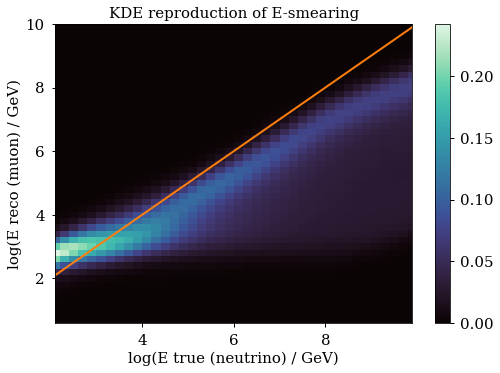

In [9]:
# logE_mids are the same as for effective area binning
egrid_true, egrid_reco = np.meshgrid(logE_mids, logE_reco_mids)

plt.grid(False)
plt.pcolormesh(egrid_true, logE_reco_mids, normed_kvals)
plt.colorbar()
plt.plot([1, 10], [1, 10], color="tab:orange")
plt.ylim(np.min(egrid_reco), np.max(egrid_reco))
plt.xlim(np.min(egrid_true), np.max(egrid_true))
plt.title("KDE reproduction of E-smearing")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")


### nice plot of expected astro events with energy smearing

In [11]:
from matplotlib.colors import LogNorm

Text(0, 0.5, '$\\sin(\\delta)$')

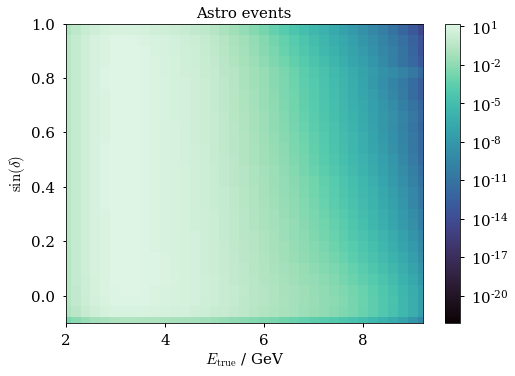

In [12]:
aeff_factor = aeff_eval_e_sd(
    aeff_2d["IceCube"],
    sindec_width, ewidth, ra_width) * LIVETIME
astro_ev = energy_smearing(
    normed_kvals,
    aeff_factor * (emids/E_NORM)**(-GAMMA_ASTRO) * PHI_ASTRO)

f, ax = plt.subplots()
im = ax.pcolormesh(
    logE_reco_bins,
    sindec_bins,
    astro_ev,
    norm=LogNorm()
)
plt.colorbar(im, ax=ax)
ax.set_ylim(-0.1, 1)
ax.set_xlim(2, 9.2)
ax.set_title("Astro events")
ax.set_xlabel(r"$E_{\rm true}$ / GeV")
ax.set_ylabel(r"$\sin(\delta)$")

## test event numbers

In [13]:
aeff_factor = aeff_eval_e_sd(
    aeff_2d["IceCube"],
    sindec_width, ewidth, ra_width) * LIVETIME
astro_ev = aeff_factor * (emids/E_NORM)**(-GAMMA_ASTRO) * PHI_ASTRO

print("original sum astro:", np.sum(astro_ev))
print("smeared sum astro:", np.sum(energy_smearing(normed_kvals, astro_ev)), "(should be numerically the same)")

original sum astro: 2890.820006608039
smeared sum astro: 2890.82000660804 (should be numerically the same)


## Simple diffuse flux fit

In [10]:
from fluxes import (
    astro_flux,
    atmo_background,
    shape_params,
    plot_spectrum
)


## plot exemplary shapes

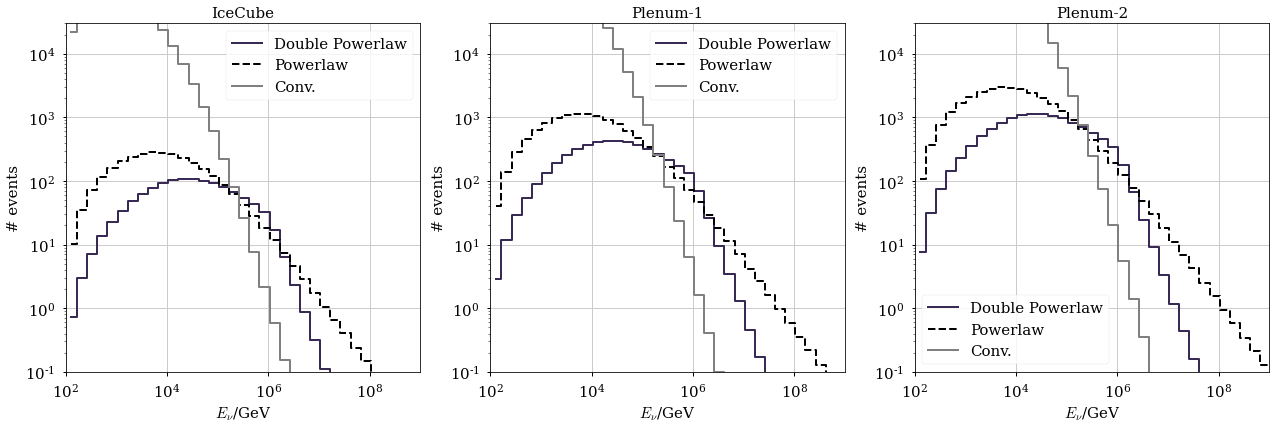

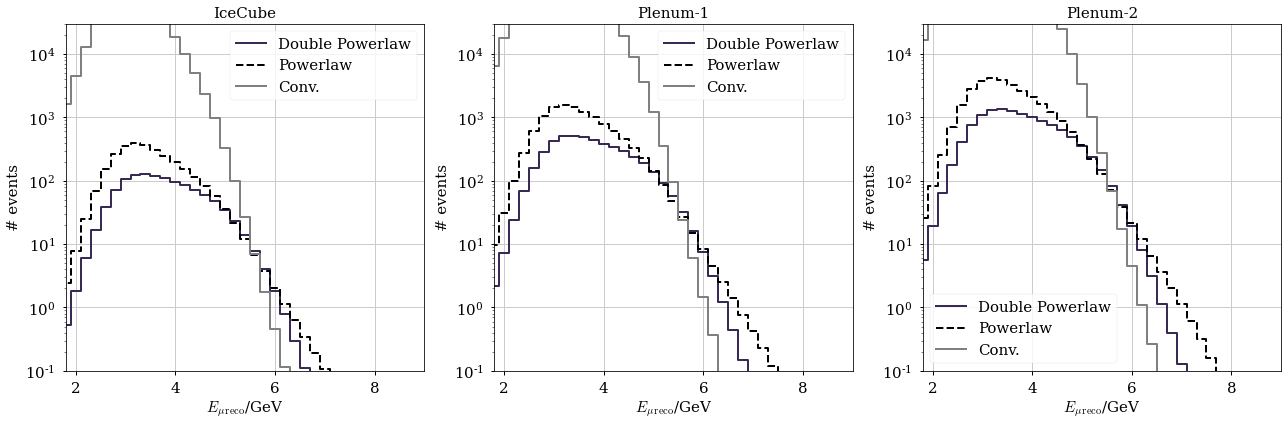

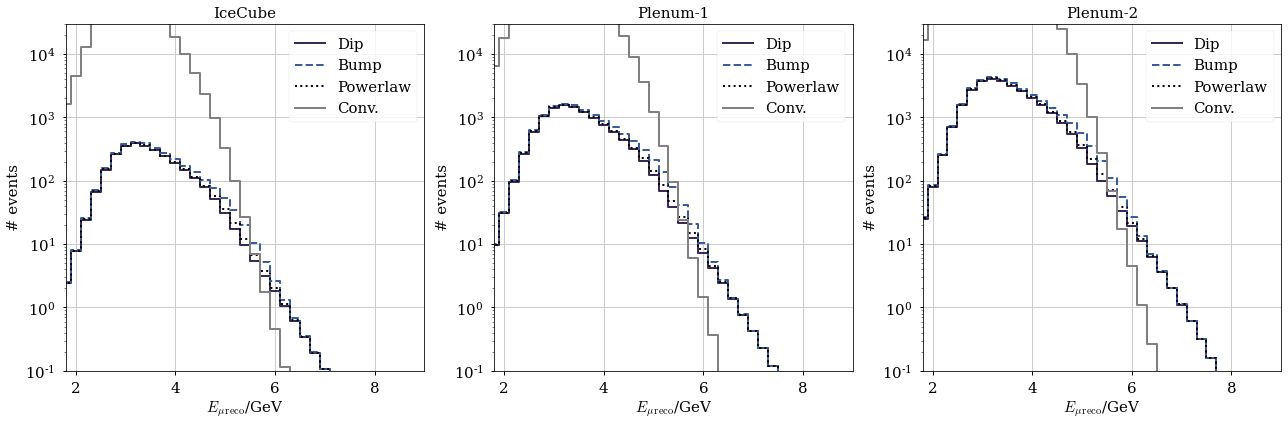

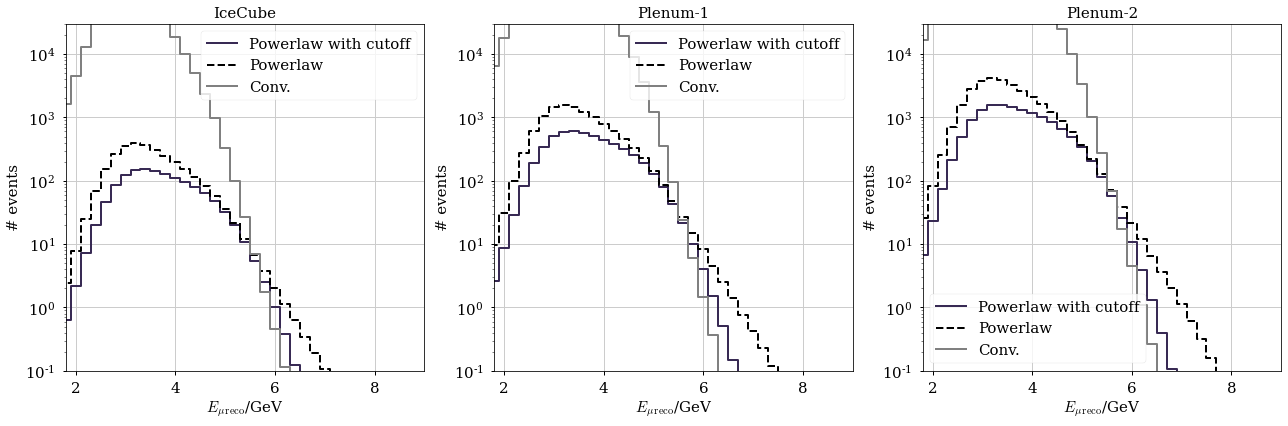

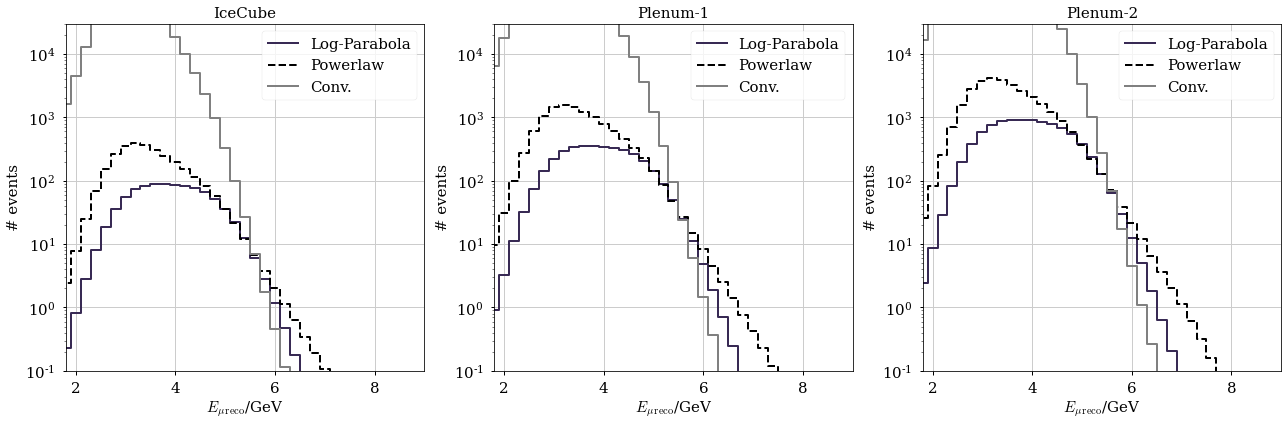

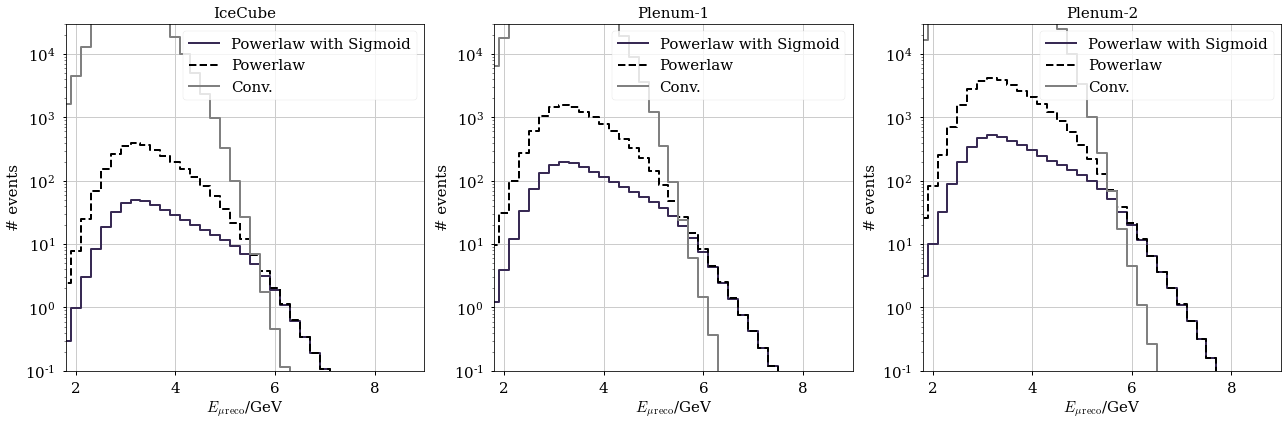

In [29]:
### true energy
idents = ["IceCube", "Plenum-1", "Plenum-2"]
f, axes = plt.subplots(ncols=3, figsize=(18, 6))
for i, ident in enumerate(idents):
    ax = axes[i]
    aeff_factor = (
        aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    )
    events = [
        np.sum(
            astro_flux(
                "double powerlaw",
                aeff_factor,
                emids,
                E_NORM,
                smear_energy=False,
                *shape_params["double powerlaw"]["baseline"][1:]
            ),
            axis=0,
        ),
        np.sum(
            astro_flux(
                "powerlaw",
                aeff_factor,
                emids,
                E_NORM,
                smear_energy=False,
                *shape_params["powerlaw"]["baseline"][1:]
            ),
            axis=0,
        ),
        np.sum(atmo_background(aeff_factor, spl_vals, smear_energy=False), axis=0),
    ]
    plot_labels = ["Double Powerlaw", "Powerlaw", "Conv."]
    ls = ["-", "--", "-"]
    color = [None, "k", "gray"]
    f, ax = plot_spectrum(
        emids,
        events,
        plot_labels,
        title=ident,
        f=f,
        ax=ax,
        ls=ls,
        color=color,
        xlabel=r"$E_{\nu}$/GeV",
        xlim=(1e2, 1e9),
    )
    ax.set_xscale("log")

## reco energy
idents = ["IceCube", "Plenum-1", "Plenum-2"]
f, axes = plt.subplots(ncols=3, figsize=(18, 6))
for i, ident in enumerate(idents):
    ax = axes[i]
    aeff_factor = (
        aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    )
    events = [
        np.sum(
            astro_flux(
                "double powerlaw",
                aeff_factor,
                emids,
                E_NORM,
                *shape_params["double powerlaw"]["baseline"][1:]
            ),
            axis=0,
        ),
        np.sum(
            astro_flux(
                "powerlaw",
                aeff_factor,
                emids,
                E_NORM,
                *shape_params["powerlaw"]["baseline"][1:]
            ),
            axis=0,
        ),
        np.sum(atmo_background(aeff_factor, spl_vals), axis=0),
    ]
    plot_labels = ["Double Powerlaw", "Powerlaw", "Conv."]
    ls = ["-", "--", "-"]
    color = [None, "k", "gray"]
    f, ax = plot_spectrum(
        logE_reco_mids, events, plot_labels, title=ident, f=f, ax=ax, ls=ls, color=color
    )


idents = ["IceCube", "Plenum-1", "Plenum-2"]
f, axes = plt.subplots(ncols=3, figsize=(18, 6))
for i, ident in enumerate(idents):
    ax = axes[i]
    aeff_factor = (
        aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    )
    events = [
        np.sum(
            astro_flux(
                "powerlaw with dip",
                aeff_factor,
                emids,
                E_NORM,
                *shape_params["powerlaw with dip"]["baseline"][1:]
            ),
            axis=0,
        ),
        np.sum(
            astro_flux(
                "powerlaw with bump",
                aeff_factor,
                emids,
                E_NORM,
                *shape_params["powerlaw with bump"]["baseline"][1:]
            ),
            axis=0,
        ),
        np.sum(
            astro_flux(
                "powerlaw",
                aeff_factor,
                emids,
                E_NORM,
                *shape_params["powerlaw"]["baseline"][1:]
            ),
            axis=0,
        ),
        np.sum(atmo_background(aeff_factor, spl_vals), axis=0),
    ]
    plot_labels = ["Dip", "Bump", "Powerlaw", "Conv."]
    ls = ["-", "--", ":", "-"]
    color = [None, None, "k", "gray"]
    f, ax = plot_spectrum(
        logE_reco_mids, events, plot_labels, title=ident, f=f, ax=ax, ls=ls, color=color
    )

idents = ["IceCube", "Plenum-1", "Plenum-2"]
f, axes = plt.subplots(ncols=3, figsize=(18, 6))
for i, ident in enumerate(idents):
    ax = axes[i]
    aeff_factor = (
        aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    )
    events = [
        np.sum(
            astro_flux(
                "powerlaw cutoff",
                aeff_factor,
                emids,
                E_NORM,
                *shape_params["powerlaw with cutoff"]["baseline"][1:]
            ),
            axis=0,
        ),
        np.sum(
            astro_flux(
                "powerlaw",
                aeff_factor,
                emids,
                E_NORM,
                *shape_params["powerlaw"]["baseline"][1:]
            ),
            axis=0,
        ),
        np.sum(atmo_background(aeff_factor, spl_vals), axis=0),
    ]
    plot_labels = ["Powerlaw with cutoff", "Powerlaw", "Conv."]
    ls = ["-", "--", "-"]
    color = [None, "k", "gray"]
    f, ax = plot_spectrum(
        logE_reco_mids, events, plot_labels, title=ident, f=f, ax=ax, ls=ls, color=color
    )

idents = ["IceCube", "Plenum-1", "Plenum-2"]
f, axes = plt.subplots(ncols=3, figsize=(18, 6))
for i, ident in enumerate(idents):
    ax = axes[i]
    aeff_factor = (
        aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    )
    events = [
        np.sum(
            astro_flux(
                "log-parabola",
                aeff_factor,
                emids,
                E_NORM,
                *shape_params["log-parabola"]["baseline"][1:]
            ),
            axis=0,
        ),
        np.sum(
            astro_flux(
                "powerlaw",
                aeff_factor,
                emids,
                E_NORM,
                *shape_params["powerlaw"]["baseline"][1:]
            ),
            axis=0,
        ),
        np.sum(atmo_background(aeff_factor, spl_vals), axis=0),
    ]
    plot_labels = ["Log-Parabola", "Powerlaw", "Conv."]
    ls = ["-", "--", "-"]
    color = [None, "k", "gray"]
    f, ax = plot_spectrum(
        logE_reco_mids, events, plot_labels, title=ident, f=f, ax=ax, ls=ls, color=color
    )

idents = ["IceCube", "Plenum-1", "Plenum-2"]
f, axes = plt.subplots(ncols=3, figsize=(18, 6))
for i, ident in enumerate(idents):
    ax = axes[i]
    aeff_factor = (
        aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    )
    events = [
        np.sum(
            astro_flux(
                "powerlaw with sigmoid",
                aeff_factor,
                emids,
                E_NORM,
                *shape_params["powerlaw with sigmoid"]["baseline"][1:]
            ),
            axis=0,
        ),
        np.sum(
            astro_flux(
                "powerlaw",
                aeff_factor,
                emids,
                E_NORM,
                *shape_params["powerlaw"]["baseline"][1:]
            ),
            axis=0,
        ),
        np.sum(atmo_background(aeff_factor, spl_vals), axis=0),
    ]
    plot_labels = ["Powerlaw with Sigmoid", "Powerlaw", "Conv."]
    ls = ["-", "--", "-"]
    color = [None, "k", "gray"]
    f, ax = plot_spectrum(
        logE_reco_mids, events, plot_labels, title=ident, f=f, ax=ax, ls=ls, color=color
    )


# Define likelihood and test statistic

In [11]:
def spectral_ts_func(x, aeff_factor, emids, enorm, k_i, shape, verbose=False, **kwargs):
    """
    Define the function to describe the composite signal+background model 
    based on poisson statistics.


    Parameters:
    ===========
    x: model parameters; First parameter is always conv scaling, rest is defined in astro_flux()
    aeff_factor: partly evaluated effective area x binning etc. -> astro_flux()
    emids: values in the mids of energy bins corresponding to effective area binning -> astro_flux()
    enorm: normalization value of astro spectrum -> astro_flux()
    k_i: "observed" number of events per bin
    shape: shape of the astrophysical neutrino flux -> astro_flux()
    kwargs: currently only 'background_spl' -> spline of atmospheric background


    Returns:
    ========
    -2 log(poisson likelihood of composite model)

    Despite the name (TS), this is not the full test statistic,
    but the -2log(likelihood of composite model) based on poisson statistics.
    The actual likelihood ratio needs to be calculated afterwards.
    """
    # free parameters
    _conv_scaling = x[0]
    background_spl = kwargs.pop("background_spl", spl_vals)
    # astro events with single powerlaw
    # this is already smeared in energy
    astro_ev = astro_flux(shape, aeff_factor, emids, enorm, *x[1:])
    if verbose:
        print(x)
        print(*x[1:])
        print(np.sum(astro_ev))
    # atm events based on MCEQ with scaling factor
    atm_ev = atmo_background(aeff_factor, background_spl * _conv_scaling)
    # this defines the LLH function with free parameters
    all_mu_i = astro_ev + atm_ev
    # -2 * log( Poisson distr)
    # with all_mu_i = mu_signal + mu_bckg as expectation value(s)
    # and k_i as the "observed" number of events
    # note: stirling approximation for k_i! ~= sqrt(2pi k_i) * (k_i/e)^k_i
    return -2 * np.sum(
        np.where(
            all_mu_i > 0,
            k_i * np.log(all_mu_i)
            - all_mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


In [12]:
def local_ts_func(x, fixed_params, free_positions, fixed_params_positions, *args):
    r""" Reduce full likelihood function with fixed parameters, i.e. reduce to
    a 'local' likelihood function. Free and fixed parameters are combined in one
    array to be piped through to 'spectral_ts_func'.
    -----------------------------------------------------------------------
    
    x: free parameters, piped through to 'spectral_ts_func'
    fixed_params: value of fixed parameters
    free_positions: array indices of free parameters
    fixed_params_positions: array indices of fixed parameters
    *args: piped through to 'spectral_ts_func'
    
    returns spectral_ts_func(free_and_fixed_parameters, *args)
    """
    all_x = np.zeros(len(x) + len(fixed_params))
    for i, pos in enumerate(fixed_params_positions):
        all_x[pos] = fixed_params[i]
    for i, pos in enumerate(free_positions):
        all_x[pos] = x[i]
    return spectral_ts_func(all_x, *args)

In [13]:
def asimov_data(aeff_factor, shape_key, verbose=False, **kwargs):
    shp_params = kwargs.pop("shp_params", np.copy(shape_params[shape_key]["baseline"]))
    background_spl = kwargs.pop("background_spl", spl_vals)
    # calculate asimov 'data' = expectation of perfect experiment
    astro_ev = astro_flux(shape_key, aeff_factor, emids, E_NORM, *shp_params[1:])
    if verbose:
        print("baseline astro ev", np.sum(astro_ev))
    atm_ev = atmo_background(aeff_factor, background_spl * shp_params[0])
    # asimov = expectation of perfect experiment
    return astro_ev + atm_ev

## Loop through all shapes and make a spectral fit

In [18]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
verbose = True
fit_results = {}
for shape in shape_params:
    print(shape)
    fit_results[shape] = {}
    for li, ident in enumerate(idents):
        if verbose: print(ident)
        aeff_factor = aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
        if "Plenum" in ident:
            aeff_factor += aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width) * LIVETIME
        # asimov = expectation of perfect experiment
        k_i = asimov_data(aeff_factor, shape, verbose=False)

        # global min
        out = fmin_l_bfgs_b(
            spectral_ts_func,
            x0=shape_params[shape]["guess"],
            bounds=shape_params[shape]["bounds"],
            approx_grad=True,
            args=(aeff_factor, emids, E_NORM, k_i, shape)
        )
        print("shape fit:", out[0])
        fit_results[shape][ident] = out
        if out[2]['warnflag'] != 0:
            print("WARNING!!")
            
        # check that the TS at the fit minimum is close to the TS of the baseline params
        baseline_ts = spectral_ts_func(
            shape_params[shape]["baseline"],
            aeff_factor, emids, E_NORM, k_i, shape
        )
        baseline_ts_check = np.isclose(
            out[1], baseline_ts, rtol=1E-3
        )
        print("TS asimov check:", "OK" if baseline_ts_check else "not OK :(")
        print("fit: ", out[1], ", reference:", baseline_ts)
        # best fit powerlaw as null hypothesis     
        out_pl = fmin_l_bfgs_b(
            spectral_ts_func,
            x0=shape_params["powerlaw"]["guess"],            
            bounds=shape_params["powerlaw"]["bounds"],
            approx_grad=True,
            args=(aeff_factor, emids, E_NORM, k_i, "powerlaw")
        )
        ## be aware: this doesn't tell you whether or not the fit worked
        ## a 2D scan can confirm (see below)
        print("pl fit:", out_pl[0])        
        pval = chi2.sf(out_pl[1] - out[1], 1)
        significance = erfinv(1 - pval) * np.sqrt(2)
        print("P-VALUE:", pval, ", SIGNIFICANCE:", significance)
        if False: #verbose:
            print("asimov baseline param: ", shape_params[shape]["baseline"])
            print("bf param:", fit_results[shape][ident][0])
            print("guess param: ", shape_params[shape]["guess"])
            print("diff (truth vs fit):", shape_params[shape]["baseline"]/ fit_results[shape][ident][0] -1)
            print("* *" * 30)
    print("- -" * 30)

powerlaw
IceCube
shape fit: [1.00000025 2.37000523 1.43989576]
TS asimov check: OK
fit:  -4298.709906613815 , reference: -4298.709906816724
pl fit: [1.00000025 2.37000523 1.43989576]
P-VALUE: 1.0 , SIGNIFICANCE: 0.0
Plenum-1
shape fit: [1.00000042 2.36996991 1.43994223]
TS asimov check: OK
fit:  -2423.9962544362243 , reference: -2423.9962549925167
pl fit: [1.00000042 2.36996991 1.43994223]
P-VALUE: 1.0 , SIGNIFICANCE: 0.0
Plenum-2
shape fit: [1.00000021 2.36996482 1.43988659]
TS asimov check: OK
fit:  -1194.1268290114676 , reference: -1194.1268336033609
pl fit: [1.00000021 2.36996482 1.43988659]
P-VALUE: 1.0 , SIGNIFICANCE: 0.0
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
powerlaw with cutoff
IceCube
shape fit: [0.99975395 2.06309886 1.51798445 6.01419399]
TS asimov check: OK
fit:  -8534.86837829254 , reference: -8534.926597222166
pl fit: [0.99828877 2.41850693 1.08938664]
P-VALUE: 0.13421141715882096 , SIGNIFICANCE: 1.4976992101613469
Plen

powerlaw


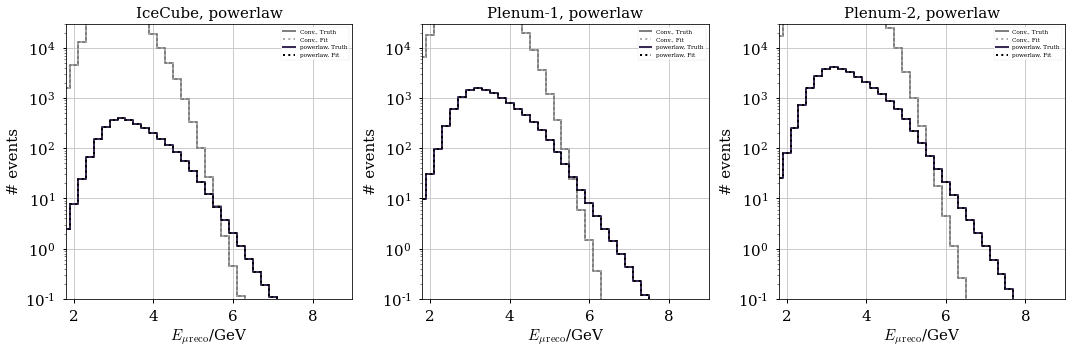

powerlaw with cutoff


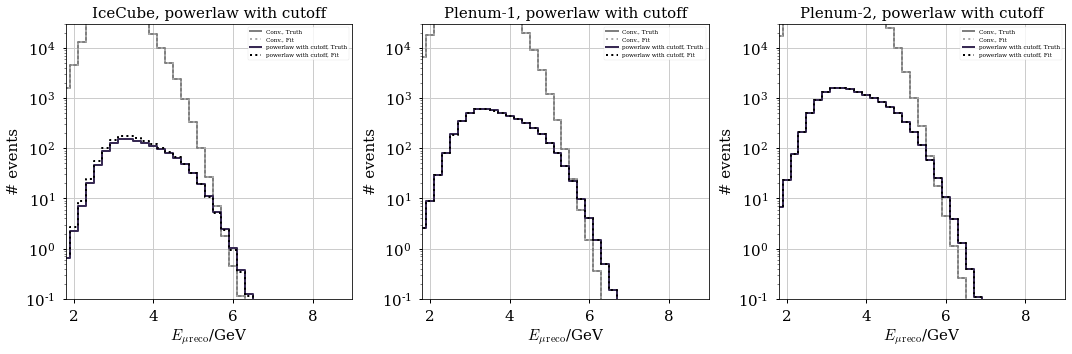

log-parabola


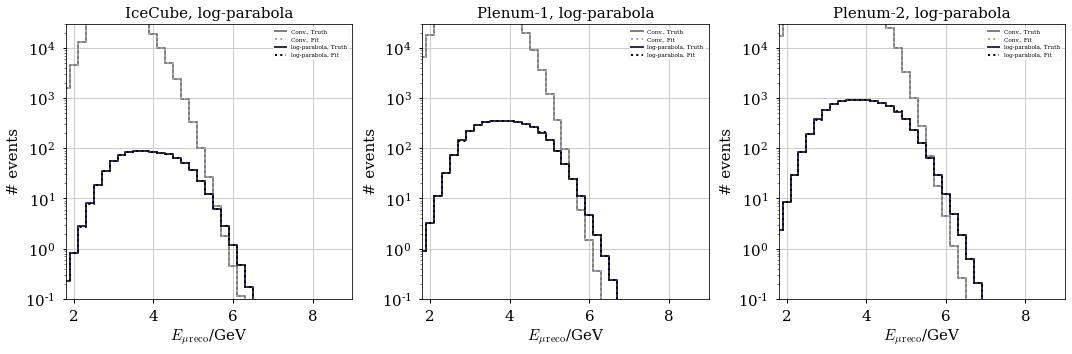

double powerlaw


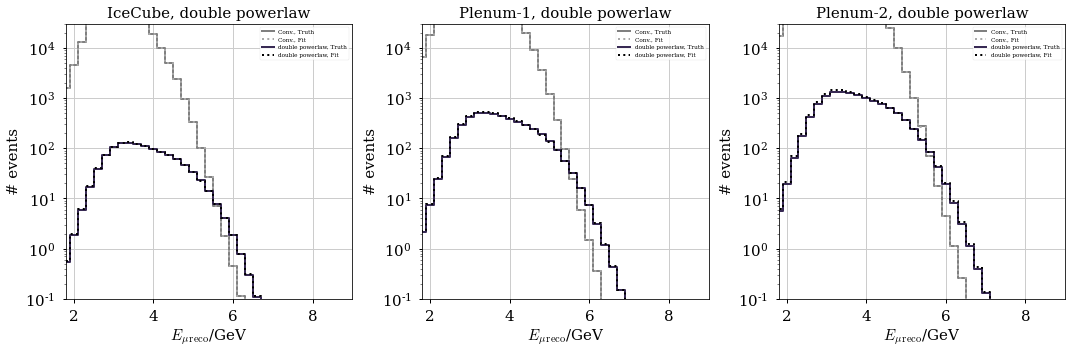

powerlaw with sigmoid


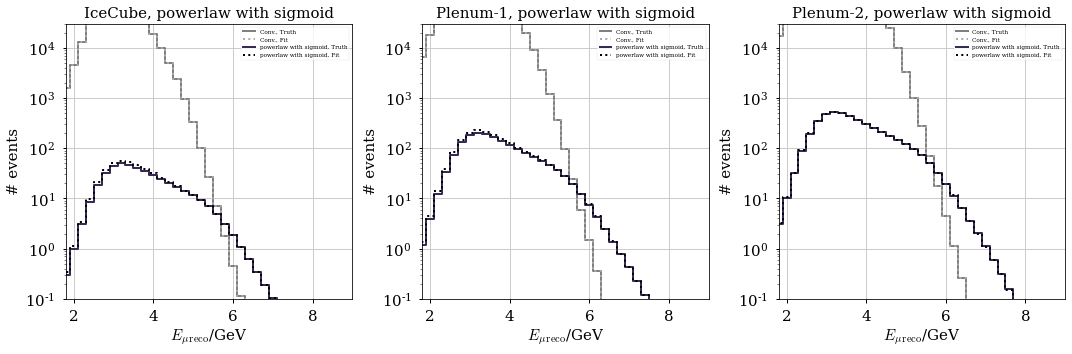

powerlaw with dip


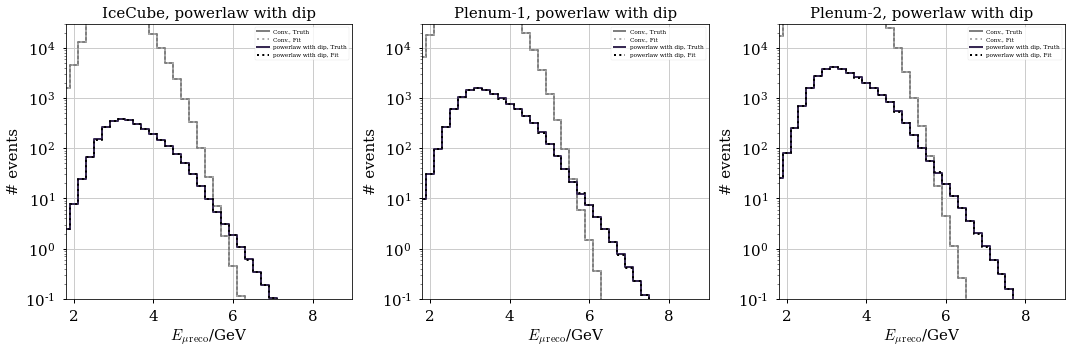

powerlaw with bump


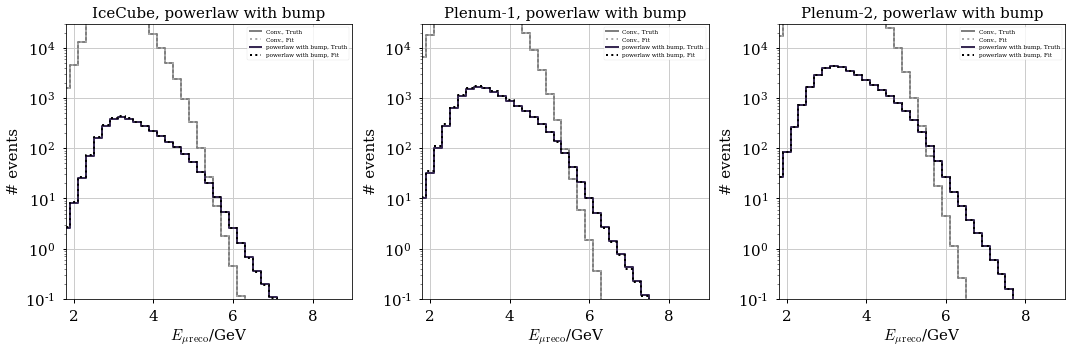

In [19]:
### make corresponding best-fit and truth plots
for shape in shape_params:
    print(shape)
    f, axes = plt.subplots(ncols=3, figsize=(15, 5))
    for li, ident in enumerate(idents):
        ax = axes[li]
        aeff_factor = aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
        events = [
            np.sum(atmo_background(aeff_factor, spl_vals * shape_params[shape]["baseline"][0]), axis=0),
            np.sum(atmo_background(aeff_factor, spl_vals * fit_results[shape][ident][0][0]), axis=0),
            np.sum(astro_flux(shape, aeff_factor, emids, E_NORM, *shape_params[shape]["baseline"][1:]), axis=0),
            np.sum(astro_flux(shape, aeff_factor, emids, E_NORM, *fit_results[shape][ident][0][1:]), axis=0)
        ]
        plot_labels = ["Conv., Truth", "Conv., Fit", shape + ", Truth", shape + ", Fit"]
        ls = ["-", ":", "-", ":"]
        color = ["gray", "darkgray", None, "k"]
        f, ax = plot_spectrum(logE_reco_mids, events, plot_labels, title=ident + ", " + shape, f=f, ax=ax, ls=ls, color=color)        
        ax.legend(fontsize="xx-small", loc=1)
        f.tight_layout()
    plt.show()


# 1D scan powerlaw
Calculate expected parameter uncertainties

In [26]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
num = 100
gamma_astro_scaling = np.linspace(2.1, 2.6, num=num + 1)
astro_scaling = np.linspace(0.4, 2.6, num=num)
verbose = False


In [27]:
bf_SPL = {"ts": {}, "conv": {}, "gamma": {}, "phi_astro": {}}
local_SPL_gamma_scan = {"ts": {}, "conv": {}, "phi_astro": {}}
local_SPL_phi_scan = {"ts": {}, "conv": {}, "gamma": {}}
shape = "powerlaw"
for ident in idents:
    print(ident)
    aeff_factor = (
        aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    )
    if "Plenum" in ident:
        aeff_factor += (
            aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width)
            * LIVETIME
        )
    # asimov = expectation of perfect experiment
    k_i = asimov_data(aeff_factor, shape, verbose=verbose)

    # global min
    out = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params[shape]["guess"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, shape),
    )
    if out[2]["warnflag"] != 0:
        print("WARNING!!")
    print("asimov param: ", shape_params[shape]["baseline"])
    print("bf param:", out[0])

    bf_SPL["ts"][ident] = out[1]
    bf_SPL["conv"][ident] = out[0][0]
    bf_SPL["gamma"][ident] = out[0][1]
    bf_SPL["phi_astro"][ident] = out[0][2]

    local_SPL_gamma_scan["ts"][ident] = np.zeros_like(gamma_astro_scaling) * np.nan
    local_SPL_gamma_scan["conv"][ident] = np.zeros_like(gamma_astro_scaling) * np.nan
    local_SPL_gamma_scan["phi_astro"][ident] = (
        np.zeros_like(gamma_astro_scaling) * np.nan
    )
    print("starting local fits...")
    for j, gas in enumerate(gamma_astro_scaling):
        # local min with fixed gamma_astro_scaling
        local_func = lambda x: spectral_ts_func(
            (x[0], gas, x[1]), aeff_factor, emids, E_NORM, k_i, shape
        )
        local_out = fmin_l_bfgs_b(local_func, x0=[1.0, 1.0], approx_grad=True, maxls=35)
        if local_out[2]["warnflag"] == 0:
            local_SPL_gamma_scan["conv"][ident][j] = local_out[0][0]
            local_SPL_gamma_scan["phi_astro"][ident][j] = local_out[0][1]
            local_SPL_gamma_scan["ts"][ident][j] = local_out[1]

    local_SPL_phi_scan["ts"][ident] = np.zeros_like(astro_scaling) * np.nan
    local_SPL_phi_scan["conv"][ident] = np.zeros_like(astro_scaling) * np.nan
    local_SPL_phi_scan["gamma"][ident] = np.zeros_like(astro_scaling) * np.nan
    print("starting local fits...")
    for j, aas in enumerate(astro_scaling):
        # local min with fixed phi_astro
        local_func = lambda x: spectral_ts_func(
            (x[0], x[1], aas), aeff_factor, emids, E_NORM, k_i, shape
        )
        local_out = fmin_l_bfgs_b(
            local_func,
            x0=[1.0, 2.2],
            approx_grad=True,
            maxls=35,
        )
        if local_out[2]["warnflag"] == 0:
            local_SPL_phi_scan["conv"][ident][j] = local_out[0][0]
            local_SPL_phi_scan["gamma"][ident][j] = local_out[0][1]
            local_SPL_phi_scan["ts"][ident][j] = local_out[1]
    print("done")


IceCube
asimov param:  [1.   2.37 1.44]
bf param: [1.00001275 2.36957116 1.43727611]
starting local fits...
starting local fits...
done
Plenum-1
asimov param:  [1.   2.37 1.44]
bf param: [1.00001451 2.36949648 1.43691392]
starting local fits...
starting local fits...
done
Plenum-2
asimov param:  [1.   2.37 1.44]
bf param: [1.00001457 2.36948645 1.43697769]
starting local fits...
starting local fits...
done


Text(0, 0.5, '-2$\\Delta$LLH')

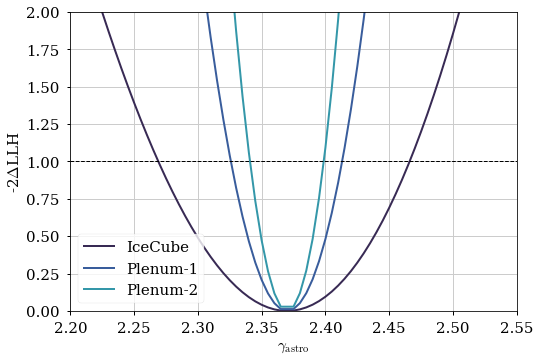

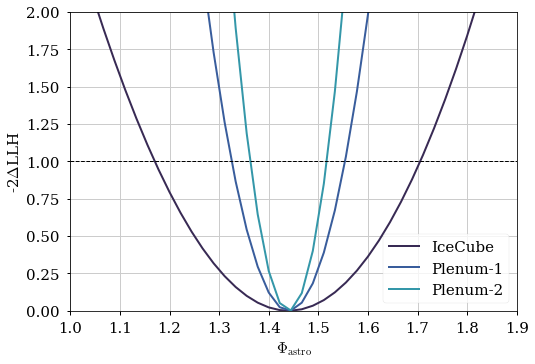

In [28]:
plt.figure()
for ident in idents:
    # mask invalid values where the fit failed
    mask = local_SPL_gamma_scan["ts"][ident] >= bf_SPL["ts"][ident]
    plt.plot(gamma_astro_scaling[mask], local_SPL_gamma_scan["ts"][ident][mask] - bf_SPL["ts"][ident], label=ident)
plt.axhline(1, ls="--", color="k", lw=1)
plt.ylim(0, 2)
plt.xlim(2.2, 2.55)
plt.legend(loc=3)
plt.xlabel(r"$\gamma_{\rm astro}$")
plt.ylabel(r"-2$\Delta$LLH")

plt.figure()
for ident in idents:
    # mask invalid values where the fit failed
    mask = local_SPL_phi_scan["ts"][ident] >= bf_SPL["ts"][ident]
    plt.plot(astro_scaling[mask], local_SPL_phi_scan["ts"][ident][mask] - bf_SPL["ts"][ident], label=ident)
plt.axhline(1, ls="--", color="k", lw=1)
plt.ylim(0, 2)
plt.xlim(1, 1.9)
plt.legend(loc=4)
plt.xlabel(r"$\Phi_{\rm astro}$")
plt.ylabel(r"-2$\Delta$LLH")

# 2D scan powerlaw
Show that we can roughly reproduce the diffuse results from ICRC2019

In [29]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
num = 60
gamma_astro_scaling = np.linspace(1.9, 2.9, num=num+1)
astro_scaling = np.linspace(0.4, 2.7, num=num)

In [30]:
bf_SPL = {"ts": {}, "conv": {}, "gamma": {}, "phi_astro": {}}
local_SPL = {"ts": {}, "conv": {}}

shape = "powerlaw"
for ident in idents:
    print(ident)
    aeff_factor = (
        aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    )
    if "Plenum" in ident:
        aeff_factor += (
            aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width)
            * LIVETIME
        )
    # asimov = expectation of perfect experiment
    k_i = asimov_data(aeff_factor, shape, verbose=verbose)

    # global min
    out = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params[shape]["guess"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, shape),
    )
    if out[2]["warnflag"] != 0:
        print("WARNING!!")
    print("asimov param: ", shape_params[shape]["baseline"])
    print("bf param:", out[0])

    bf_SPL["ts"][ident] = out[1]
    bf_SPL["conv"][ident] = out[0][0]
    bf_SPL["gamma"][ident] = out[0][1]
    bf_SPL["phi_astro"][ident] = out[0][2]

    local_SPL["ts"][ident] = np.zeros((num, num + 1))
    local_SPL["conv"][ident] = np.zeros((num, num + 1))
    print("starting local fits...")
    for i, asc in enumerate(astro_scaling):
        for j, gas in enumerate(gamma_astro_scaling):
            # local min with fixed phi_astro
            local_func = lambda x: spectral_ts_func(
                (x[0], gas, asc), aeff_factor, emids, E_NORM, k_i, shape
            )
            local_out = fmin_l_bfgs_b(
                local_func,
                x0=[1.1],
                approx_grad=True,
            )
            (local_SPL["conv"][ident][i][j],) = local_out[0]
            local_SPL["ts"][ident][i][j] = local_out[1]
    print("done")


IceCube
asimov param:  [1.   2.37 1.44]
bf param: [1.00001275 2.36957116 1.43727611]
starting local fits...
done
Plenum-1
asimov param:  [1.   2.37 1.44]
bf param: [1.00001451 2.36949648 1.43691392]
starting local fits...
done
Plenum-2
asimov param:  [1.   2.37 1.44]
bf param: [1.00001457 2.36948645 1.43697769]
starting local fits...
done


## contour comparison

In [31]:
# comparison data of official 9.5yr fit by Jöran Stettner (IceCube ICRC2019)
diffuse_10yr_ref = np.genfromtxt("../resources/diffuse_contour_95_2021.txt")

In [32]:
from settings import poles

In [33]:
### only 95% contours
contour_formats = {
    "IceCube": {"colors": [poles["IceCube"]["color"]], "linestyles": "--"},
    "Plenum-1": {
        "colors": [poles["Plenum-1"]["color"]],
        "linestyles": poles["Plenum-1"]["ls"],
    },
    "Plenum-2": {
        "colors": [poles["Plenum-2"]["color"]],
        "linestyles": poles["Plenum-2"]["ls"],
    },
}


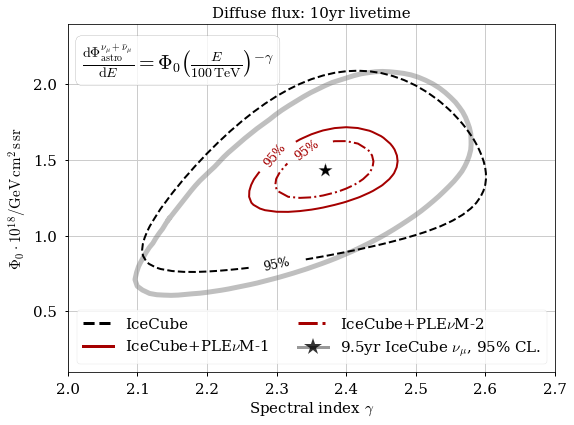

In [34]:
f, ax = plt.subplots(figsize=(8, 6))
## correctly sort extracted contour from joeran's latest diffuse fit
ref_color = "gray"
ax.plot(
    diffuse_10yr_ref[0],
    diffuse_10yr_ref[1],
    color=ref_color,
    ls="-",
    lw=5,
    alpha=0.5,
)

# draw contour levels
cvals = [0.05]
lbs = ["95%"]
levels = chi2.isf(cvals, 2)
for ident in idents:
    sc = ax.contour(
        gamma_astro_scaling,
        astro_scaling,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        levels=levels,
        lw=3,
        **contour_formats[ident],
    )
    fmt = {l: s for l, s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=12)
# best fit
ax.scatter(
    bf_SPL["gamma"][ident],
    bf_SPL["phi_astro"][ident],
    marker="*",
    s=200,
    color="k",
    edgecolor=ref_color,
)
lines = [
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["IceCube"]["colors"][0],
        ls=contour_formats["IceCube"]["linestyles"],
        lw=3,
        label="IceCube",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-1"]["colors"][0],
        ls=contour_formats["Plenum-1"]["linestyles"],
        lw=3,
        label=r"IceCube+PLE$\nu$M-1",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-2"]["colors"][0],
        ls=contour_formats["Plenum-2"]["linestyles"],
        lw=3,
        label=r"IceCube+PLE$\nu$M-2",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=ref_color,
        ls="-",
        lw=3,
        markersize=18,
        alpha=0.8,
        marker="*",
        mfc="k",
        mec=ref_color,
        label=r"9.5yr IceCube $\nu_\mu$, 95% CL.",
    ),
]
ax.set_ylim(0.1, 2.4)
ax.set_xlim(2.0, 2.7)
ax.legend(handles=lines, loc=4, ncol=2, fontsize=15)
ax.set_ylabel(r"$\Phi_0 \cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$")
ax.set_xlabel(r"Spectral index $\gamma$")
flux_str = r"$\frac{{\rm d}\Phi_{\rm astro}^{\nu_\mu + \bar{\nu}_\mu}}{{\rm d}E}"
flux_str += r"= \Phi_0 \left( \frac{E}{\rm 100\,TeV} \right)^{-\gamma}$"
ax.text(
    2.02,
    2.1,
    flux_str,
    fontsize=20,
    bbox=dict(boxstyle="round", facecolor="w", edgecolor="gray", alpha=0.8),
)
ax.set_title("Diffuse flux: 10yr livetime")
f.tight_layout()
f.savefig(f"../plots/2D_scan_diffuse_spl_comparison.pdf")


### full scan comparison

IceCube
Plenum-1
Plenum-2


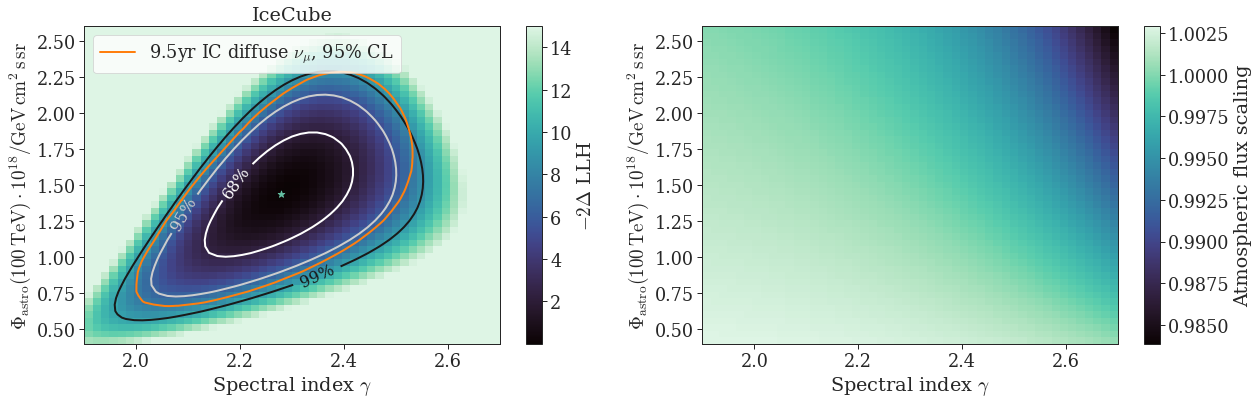

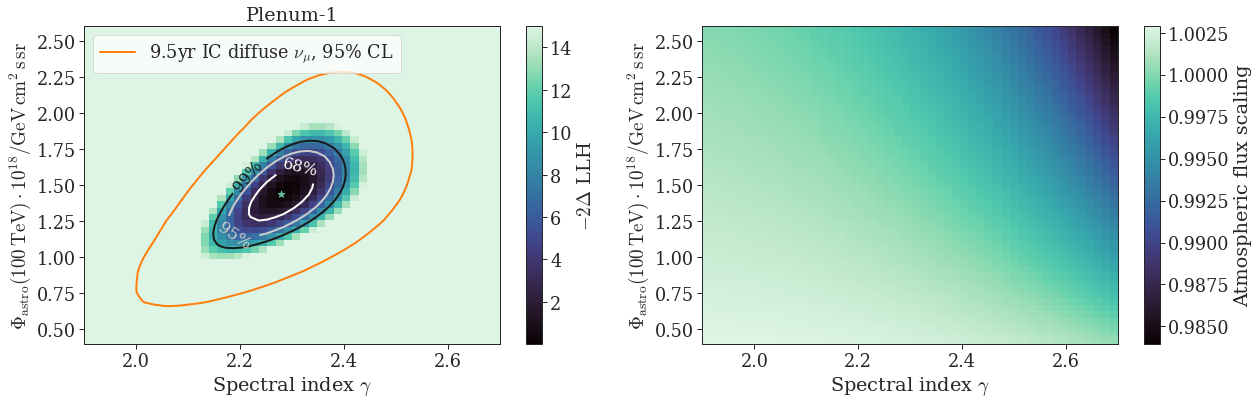

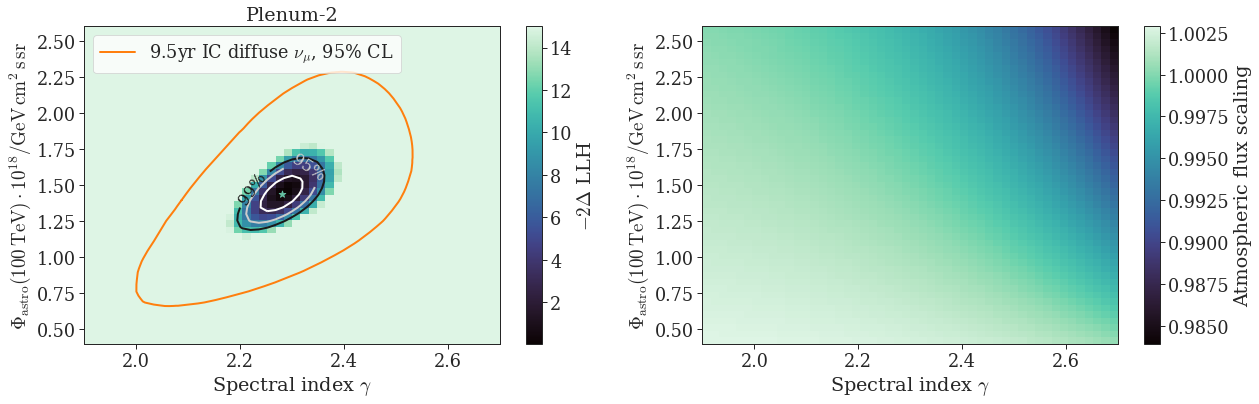

In [65]:
ref_color = "tab:orange"
for ident in idents:
    print(ident)
    ### plotting ###
    f, axes = plt.subplots(ncols=2, figsize=(18,6))
    ax = axes[0]
    # draw llh grid for gamma and astro flux
    im = ax.pcolormesh(
        gamma_astro_scaling,
        astro_scaling,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        vmax=15 # 6 is approx. the 95% quantile of a 2D LLH scan
    )
    cb = plt.colorbar(im, ax=ax)
    # draw contour levels
    cvals = np.array([0.32, 0.05, 0.01])
    levels = chi2.isf(cvals, 2)
    lbs = np.array(["68%", "95%", "99%"])
    sc = ax.contour(
        gamma_astro_scaling,
        astro_scaling,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        levels=levels,
        colors=["w", "0.8", "k"]
    )
    ax.scatter(bf_SPL["gamma"][ident], bf_SPL["phi_astro"][ident], marker="*", s=50)
    fmt = {l: s for l,s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    ax.plot(diffuse_10yr_ref[:,0], diffuse_10yr_ref[:,1], color=ref_color, label=r"9.5yr IC diffuse $\nu_\mu$, 95% CL")
    ax.legend(loc=2)
    ax.set_ylabel(r"$\Phi_{\rm astro} (100\,{\rm TeV})\cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb.set_label(r"$-2 \Delta$ LLH")
    ax.set_title(ident)


    # in addition, check the nuisance parameter of conventional flux
    ax = axes[1]
    im = ax.pcolormesh(
        gamma_astro_scaling,
        astro_scaling,
        local_SPL["conv"][ident],
    )
    ax.set_ylabel(r"$\Phi_{\rm astro} (100\,{\rm TeV})\cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"Atmospheric flux scaling")

    f.tight_layout()
    f.savefig(f"../plots/2D_scan_diffuse_spl_{ident}.pdf")

## 1D scan with cutoff

IceCube
starting local fits...
alternative: powerlaw fit (conv, gamma, phi_astro) [0.99828938 2.41851549 1.08918381]
params at min verified with scan: (conv, gamma, phi_astro) 0.9984249275871718 2.14 1.841379310344828
min TS: -1145.6163730546677 verified with scan: -1145.605630739401
Raw TS vals of powerlaw vs cutoff: -1145.6163730546677 -1147.9176927013764
P-VALUE: 0.12926413376884227 , SIGNIFICANCE: 1.5170101010568906
Plenum-1
starting local fits...
alternative: powerlaw fit (conv, gamma, phi_astro) [0.99830462 2.41440632 1.10017838]
params at min verified with scan: (conv, gamma, phi_astro) 0.9984351558194038 2.14 1.841379310344828
min TS: 66.82166784276978 verified with scan: 66.85416971072482
Raw TS vals of powerlaw vs cutoff: 66.82166784276978 57.90883843507163
P-VALUE: 0.002831741860268942 , SIGNIFICANCE: 2.9854362173220594
Plenum-2
starting local fits...
alternative: powerlaw fit (conv, gamma, phi_astro) [0.99830201 2.41614598 1.09368469]
params at min verified with scan: (conv

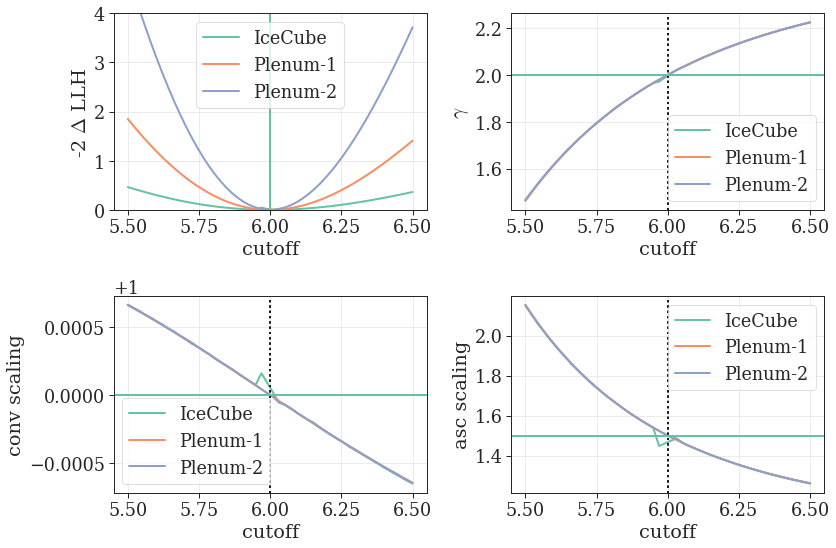

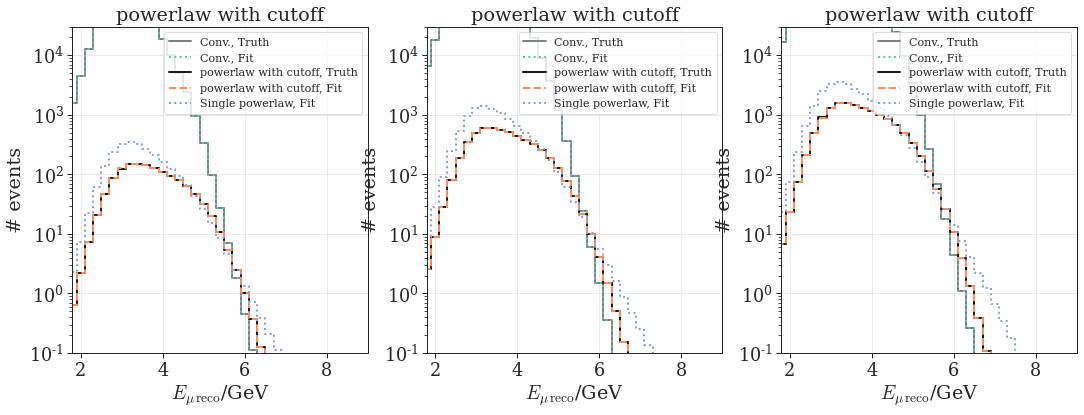

In [66]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
verbose = False
num = 50
cutoff = np.linspace(5.5, 6.5, num=num)

num1 = 30
gamma_astro_scaling = np.linspace(1.9, 2.7, num=num1+1)
astro_scaling = np.linspace(0.4, 2.6, num=num1)

ts_mins_pl = {}
gamma_mins_pl = {}
phi_astro_mins_pl = {}

f, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
f1, axes1 = plt.subplots(ncols=3, figsize=(18, 6))
for li, ident in enumerate(idents):
    print(ident)
    shape = "powerlaw with cutoff"
    aeff_factor = aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    # asimov = expectation of perfect experiment
    k_i = asimov_data(aeff_factor, shape, verbose=verbose)  

    # global min
    out = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params[shape]["guess"],
        bounds=shape_params[shape]["bounds"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, shape)
    )
    if out[2]['warnflag'] != 0:
        print("WARNING!!")
    if verbose:
        print("asimov param: ", *shape_params[shape]["baseline"][1:])
        print("guess param: ", *shape_params[shape]["guess"])
        print("bf param:", out[0])
        print("TS:", out[1])
        print("* *"*20)

    local_ts_min = np.zeros(num)
    local_param_min = {
        "gamma": np.zeros(num),
        "conv": np.zeros(num),
        "asc": np.zeros(num)
    }
    for i, cc in enumerate(cutoff):
        # local min with fixed phi_astro
        local_out = fmin_l_bfgs_b(
            local_ts_func,
            x0=shape_params[shape]["guess"][:3],
            bounds=shape_params[shape]["bounds"][:3],
            approx_grad=True,
            args=([cc], (0, 1, 2), (3,), aeff_factor, emids, E_NORM, k_i, shape)
        )
        local_param_min["conv"][i], local_param_min["gamma"][i], local_param_min["asc"][i] = local_out[0]
        local_ts_min[i] = local_out[1]
    
    # best fit powerlaw as null hypothesis     
    out_pl = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params["powerlaw"]["guess"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, "powerlaw")
    )
    gamma_mins_pl[ident] = out_pl[0][1]
    phi_astro_mins_pl[ident] = out_pl[0][2]
    ts_mins_pl[ident] = out_pl[1]
    
    ### verify with 2D scan that the result is the correct minimum
    local_ts_min_pl = np.zeros((num1, num1+1))
    local_conv_min_pl = np.zeros((num1, num1+1))
    print("starting local fits...")
    # scan
    for i, asc in enumerate(astro_scaling):
        for j, gas in enumerate(gamma_astro_scaling):
            # local min with fixed phi_astro
            local_out = fmin_l_bfgs_b(
                local_ts_func,
                x0=[1.1],
                approx_grad=True,
                args=([gas, asc], (0, ), (1, 2), aeff_factor, emids, E_NORM, k_i, "powerlaw")
            )
            local_conv_min_pl[i][j], = local_out[0]
            local_ts_min_pl[i][j] = local_out[1]    
    print("alternative: powerlaw fit (conv, gamma, phi_astro)", out_pl[0])
    iag, ias = np.unravel_index(local_ts_min_pl.argmin(), local_ts_min_pl.shape)
    print("params at min verified with scan: (conv, gamma, phi_astro)", 
          local_conv_min_pl.flatten()[local_ts_min_pl.argmin()], gamma_astro_scaling[iag], astro_scaling[ias])
    print("min TS:", out_pl[1], "verified with scan:", np.min(local_ts_min_pl))
    print("Raw TS vals of powerlaw vs cutoff:",out_pl[1], out[1])
    pval = chi2.sf(out_pl[1] - out[1], 1)
    significance = erfinv(1 - pval) * np.sqrt(2)
    print("P-VALUE:", pval, ", SIGNIFICANCE:", significance)

    # plot best-fit event distributions and truth
    
    ax = axes1[li]
    events = [
        np.sum(atmo_background(aeff_factor, spl_vals * shape_params[shape]["baseline"][0]), axis=0),
        np.sum(atmo_background(aeff_factor, spl_vals * out[0][0]), axis=0),
        np.sum(astro_flux(shape, aeff_factor, emids, E_NORM, *shape_params[shape]["baseline"][1:]), axis=0),
        np.sum(astro_flux(shape, aeff_factor, emids, E_NORM, *out[0][1:]), axis=0),
        np.sum(astro_flux("powerlaw", aeff_factor, emids, E_NORM, *out_pl[0][1:]), axis=0)
    ]
    plot_labels = ["Conv., Truth", "Conv., Fit", shape + ", Truth", shape + ", Fit", "Single powerlaw, Fit"]
    ls = ["-", ":", "-", "--", ":"]
    color = ["gray", None, "k", None, None]
    f, ax = plot_spectrum(logE_reco_mids, events, plot_labels, title=shape, f=f, ax=ax, ls=ls, color=color)        
    ax.legend(fontsize="xx-small", loc=1, ncol=2)
    f.tight_layout()

    ## some plots for checking that the scans were ok
    ax = axes[0][0]
    ax.plot(cutoff, local_ts_min- out[1], label=ident)
    ax.set_ylabel(r"-2 $\Delta$ LLH")
    ax.set_xlabel("cutoff")
    ax.legend(loc=0)
    ax.axvline(shape_params[shape]["baseline"][-1], color="k", ls=":")
    ax.axvline(out[0][-1])
    ax.set_ylim(0, 4)
    
    ax = axes[0][1]
    ax.set_ylabel(r"$\gamma$")
    ax.set_xlabel("cutoff")
    ax.plot(cutoff, local_param_min["gamma"], label=ident)
    ax.legend(loc=0)
    ax.axvline(shape_params[shape]["baseline"][-1], color="k", ls=":")
    ax.axhline(shape_params["powerlaw with cutoff"]["baseline"][1])
    
    ax = axes[1][0]
    ax.set_ylabel(r"conv scaling")
    ax.set_xlabel("cutoff")
    ax.plot(cutoff, local_param_min["conv"], label=ident)
    ax.legend(loc=0)
    ax.axvline(shape_params[shape]["baseline"][-1], color="k", ls=":")
    ax.axhline(shape_params["powerlaw with cutoff"]["baseline"][0])
    
    
    ax = axes[1][1]
    ax.set_ylabel(r"asc scaling")
    ax.set_xlabel("cutoff")
    ax.plot(cutoff, local_param_min["asc"], label=ident)
    ax.legend(loc=0)
    ax.axvline(shape_params[shape]["baseline"][-1], color="k", ls=":")
    ax.axhline(shape_params["powerlaw with cutoff"]["baseline"][2])
    axes1[li].legend(fontsize="xx-small", loc=0)
f.tight_layout()

## 2D scans with cutoff

In [72]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
verbose = False
num = 50
cutoff = np.linspace(4.5, 8.5, num=num)
gamma_astro_scaling = np.linspace(1.0, 2.9, num=num)

In [73]:
bf_PLC = {"ts": {}, "conv": {}, "gamma": {}, "phi_astro": {}, "cutoff": {}}
local_mins_PLC = {"ts": {}, "conv": {}, "phi_astro": {}}
shape = "powerlaw with cutoff"

for li, ident in enumerate(idents):
    print(ident)
    aeff_factor = (
        aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    )
    # asimov = expectation of perfect experiment
    k_i = asimov_data(aeff_factor, shape, verbose=verbose)

    # global min
    out = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params[shape]["guess"],
        bounds=shape_params[shape]["bounds"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, shape),
    )
    bf_PLC["ts"][ident] = out[1]
    (
        bf_PLC["conv"][ident],
        bf_PLC["gamma"][ident],
        bf_PLC["phi_astro"][ident],
        bf_PLC["cutoff"][ident],
    ) = out[0]
    if out[2]["warnflag"] != 0:
        print("WARNING!! Something weird happened with the fit")

    local_mins_PLC["ts"][ident] = np.zeros((len(cutoff), len(gamma_astro_scaling)))
    local_mins_PLC["conv"][ident] = np.zeros((len(cutoff), len(gamma_astro_scaling)))
    local_mins_PLC["phi_astro"][ident] = np.zeros(
        (len(cutoff), len(gamma_astro_scaling))
    )
    print("starting local fits...")
    # scan
    nwarn = 0
    for i, csc in enumerate(cutoff):
        for j, gas in enumerate(gamma_astro_scaling):
            # local min with fixed phi_astro
            local_func = lambda x: spectral_ts_func(
                (x[0], gas, x[1], csc), aeff_factor, emids, E_NORM, k_i, shape
            )
            local_out = fmin_l_bfgs_b(
                local_func,
                x0=shape_params[shape]["baseline"][[0, 2]],
                bounds=shape_params[shape]["bounds"][[0, 2]]
                * ((1, 1), (0.3, 3)),  # losen up bounds a bit here for astro
                approx_grad=True,
                maxls=35,
            )
            if local_out[2]["warnflag"] == 0:
                (
                    local_mins_PLC["conv"][ident][i][j],
                    local_mins_PLC["phi_astro"][ident][i][j],
                ) = local_out[0]
                local_mins_PLC["ts"][ident][i][j] = local_out[1]
            else:
                strng = "WARNING!! Something weird happened with the fit"
                strng += "\nParameters: cutoff={}, gamma={}".format(csc, gas)
                strng += "\n Fit Output:" + str(local_out)
                # print(strng)
                local_mins_PLC["conv"][ident][i][j] = np.nan
                local_mins_PLC["phi_astro"][ident][i][j] = np.nan
                local_mins_PLC["ts"][ident][i][j] = np.nan
                nwarn += 1
    print("Number of warnings:", nwarn)
    print("Done")


IceCube
starting local fits...
Number of warnings: 4
Done
Plenum-1
starting local fits...
Number of warnings: 2
Done
Plenum-2
starting local fits...
Number of warnings: 2
Done


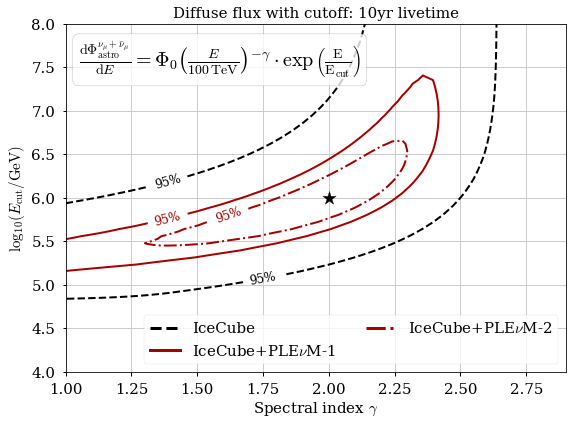

In [75]:
f, ax = plt.subplots(figsize=(8, 6))
cvals = [0.05]
lbs = ["95%"]
levels = chi2.isf(cvals, 2)
for ident in idents:
    # draw contour levels
    sc = ax.contour(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["ts"][ident] - bf_PLC["ts"][ident],
        levels=levels,
        lw=3, **contour_formats[ident]
    )
    fmt = {l: s for l,s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=12)
    
ax.scatter(bf_PLC["gamma"][ident], bf_PLC["cutoff"][ident], marker="*", s=200, color="k")
handles, _ = ax.get_legend_handles_labels()
handles.extend([
    matplotlib.lines.Line2D(
        range(1), range(1), 
        color=contour_formats["IceCube"]["colors"][0], ls=contour_formats["IceCube"]["linestyles"], lw=3, label="IceCube"),
    matplotlib.lines.Line2D(
        range(1), range(1), 
        color=contour_formats["Plenum-1"]["colors"][0], ls=contour_formats["Plenum-1"]["linestyles"], lw=3, label=r"IceCube+PLE$\nu$M-1"),    
    matplotlib.lines.Line2D(
        range(1), range(1), 
        color=contour_formats["Plenum-2"]["colors"][0], ls=contour_formats["Plenum-2"]["linestyles"], lw=3, label=r"IceCube+PLE$\nu$M-2")
])
ax.legend(handles=handles, loc=4, ncol=2, fontsize=15)
ax.set_ylim(4.0, 8)
flux_str = r"$\frac{{\rm d}\Phi_{\rm astro}^{\nu_\mu + \bar{\nu}_\mu}}{{\rm d}E}"
flux_str += r"= \Phi_0 \left( \frac{E}{\rm 100\,TeV} \right)^{-\gamma}"
flux_str += r" \cdot \exp \left( \frac{E}{E_{\rm cut}}\right)$"
ax.text(
    1.05, 7.5, flux_str, fontsize=20,
    bbox=dict(boxstyle='round', facecolor="w", edgecolor="gray", alpha=0.8)
)
ax.set_ylabel(r"$\log_{10}(E_{\rm cut} / {\rm GeV})$")
ax.set_xlabel(r"Spectral index $\gamma$")
ax.set_title("Diffuse flux with cutoff: 10yr livetime")
f.tight_layout()
f.savefig(f"../plots/2D_scan_diffuse_pl-cut_comparison_gamma-cut.pdf")

IceCube
Plenum-1
Plenum-2


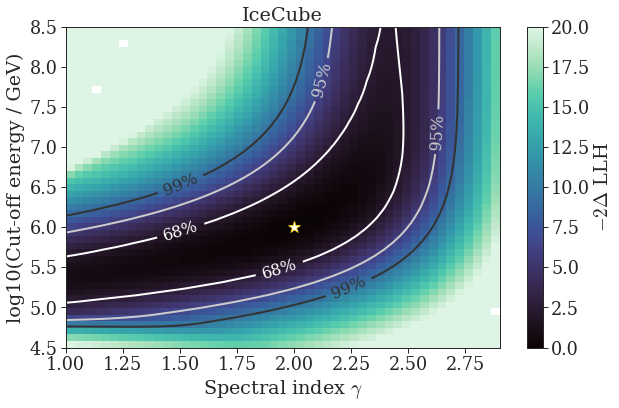

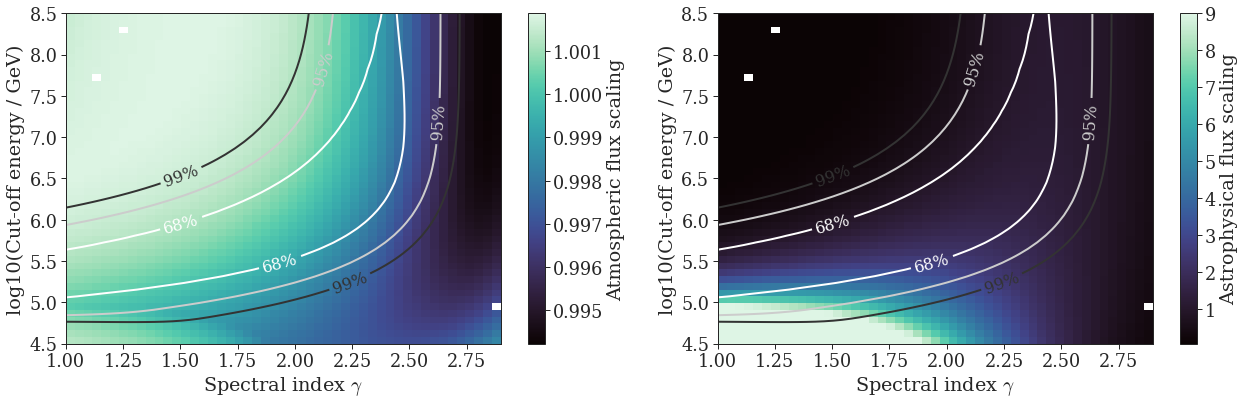

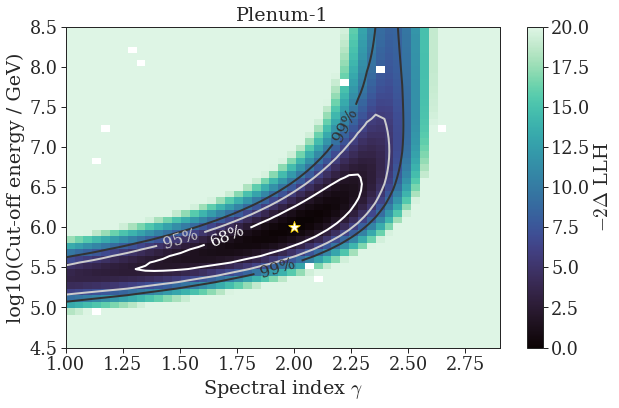

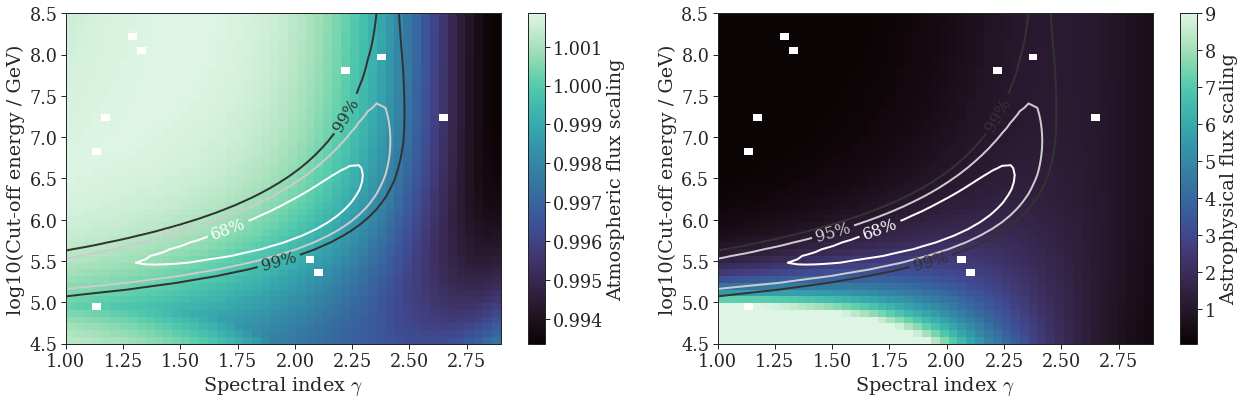

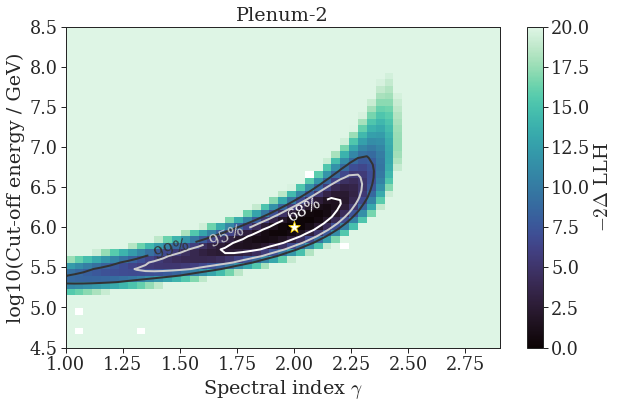

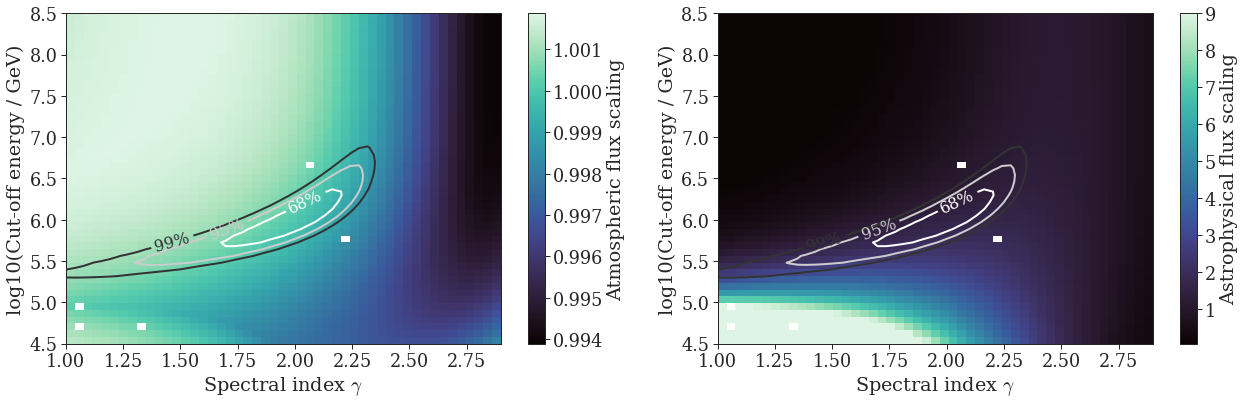

In [71]:
### white pixels are failed fits
for ident in idents:
    print(ident)
    ### plotting ###
    f, ax = plt.subplots(figsize=(9,6))
    # draw llh grid for gamma and astro flux
    im = ax.pcolormesh(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["ts"][ident] - bf_PLC["ts"][ident],
        vmin=0,
        vmax=20
    )
    cb = plt.colorbar(im, ax=ax)
    
    # draw contour levels
    cvals = np.array([0.32, 0.05, 0.01])
    levels = chi2.isf(cvals, 2)
    lbs = np.array(["68%", "95%", "99%"])
    sc = ax.contour(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["ts"][ident] - bf_PLC["ts"][ident],
        levels=levels,
        colors=["w", "0.8", "0.2"]
    )
    ax.scatter(bf_PLC["gamma"][ident], bf_PLC["cutoff"][ident], marker="*", s=150, color="white", edgecolor="gold")
    fmt = {l: s for l,s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    
    ax.set_ylabel(r"log10(Cut-off energy / GeV)")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb.set_label(r"$-2 \Delta$ LLH")
    ax.set_title(ident)
    f.tight_layout()
    f.savefig(f"../plots/2D_scan_diffuse_pl-cut_{ident}.pdf")

    f2, ax2 = plt.subplots(ncols=2, figsize=(18,6))
    ## in addition, check the nuisance parameter of conventional flux
    ax = ax2[0]
    im = ax.pcolormesh(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["conv"][ident],
        #vmin=0.99,
    )
    
    ## add contours as reference
    sc = ax.contour(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["ts"][ident] - bf_PLC["ts"][ident],
        levels=levels,
        colors=["w", "0.8", "0.2"]
    )
    fmt = {l: s for l,s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    ax.set_ylabel(r"log10(Cut-off energy / GeV)")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"Atmospheric flux scaling")
    f.tight_layout()
    
    ax = ax2[1]
    im2 = ax.pcolormesh(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["phi_astro"][ident],
        #vmin=0.99,
    )
    ## add contours as reference
    sc = ax.contour(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["ts"][ident] - bf_PLC["ts"][ident],
        levels=levels,
        colors=["w", "0.8", "0.2"]
    )
    fmt = {l: s for l,s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    ax.set_ylabel(r"log10(Cut-off energy / GeV)")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im2, ax=ax)
    cb.set_label(r"Astrophysical flux scaling")
    f2.tight_layout()
    

# Cutoff significance versus time/detectors

Some options:
* 10yr IceCube
* 20yr IceCube
* 40yr IceCube
* 10yr IceCube + K3N
* 10yr IceCube + K3N + GVD
* 10yr IceCube + K3N + GVD + PONE
* 10yr IceCube +  2yr baseline Plenum (= IC + PONE + GVD + K3N)
* 10yr IceCube +  5yr baseline Plenum (= IC + PONE + GVD + K3N)
* 10yr IceCube + 10yr baseline Plenum (= IC + PONE + GVD + K3N)
* 10yr IceCube +  2yr Plenum-2 (= GEN2 + PONE + GVD + K3N)
* 10yr IceCube +  5yr Plenum-2 (= GEN2 + PONE + GVD + K3N)
* 10yr IceCube + 10yr Plenum-2 (= GEN2 + PONE + GVD + K3N)

In [77]:
import pandas as pd

In [78]:
# livetime relative to 10yrs
detector_configurations = [
    {"IceCube": 1.0, "Gen-2": 0, "Plenum-1": 0, "KM3NeT":  0, "P-ONE": 0, "Baikal-GVD": 0, "identifier": "10y IC"},
    {"IceCube": 2.0, "Gen-2": 0, "Plenum-1": 0, "KM3NeT":  0, "P-ONE": 0, "Baikal-GVD": 0, "identifier": "20y IC"},
    {"IceCube": 4.0, "Gen-2": 0, "Plenum-1": 0, "KM3NeT":  0, "P-ONE": 0, "Baikal-GVD": 0, "identifier": "40y IC"},
    {"IceCube": 1.0, "Gen-2": 0, "Plenum-1": 0.2, "KM3NeT":  0, "P-ONE": 0, "Baikal-GVD": 0, "identifier": "10y IC + 2y PL-1"},
    {"IceCube": 1.0, "Gen-2": 0, "Plenum-1": 0.5, "KM3NeT":  0, "P-ONE": 0, "Baikal-GVD": 0, "identifier": "10y IC + 5y PL-1"},
    {"IceCube": 1.0, "Gen-2": 0, "Plenum-1": 1, "KM3NeT":  0, "P-ONE": 0, "Baikal-GVD": 0, "identifier": "10y IC + 10y PL-1"},
    {"IceCube": 1.0, "Gen-2": 0.2, "Plenum-1": 0, "KM3NeT": 0.2, "P-ONE": 0.2, "Baikal-GVD": 0.2, "identifier": "10y IC + 2y PL-2"},
    {"IceCube": 1.0, "Gen-2": 0.5, "Plenum-1": 0, "KM3NeT": 0.5, "P-ONE": 0.5, "Baikal-GVD": 0.5, "identifier": "10y IC + 5y PL-2"},
    {"IceCube": 1.0, "Gen-2": 1, "Plenum-1": 0, "KM3NeT": 1, "P-ONE": 1, "Baikal-GVD": 1, "identifier": "10y IC + 10y PL-2"},
]
detector_configurations = pd.DataFrame(detector_configurations)

In [87]:
pvals = []
shape = "powerlaw with cutoff"

for idx, series in detector_configurations.iterrows():
    print(idx)
    aeff_factor = np.zeros_like(aeff_2d["IceCube"].T)
    naming = ""
    for ident, lt_factor in series.items():
        if ident=="identifier": continue
        if lt_factor==0 : continue
        print(ident)
        aeff_factor += aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME * lt_factor
    # asimov = expectation of perfect experiment
    k_i = asimov_data(aeff_factor, shape, verbose=verbose)  

    # global min
    out = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params[shape]["guess"],
        bounds=shape_params[shape]["bounds"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, shape)
    )
    # check that the TS at the fit minimum is close to the TS of the baseline params
    baseline_ts_check = np.isclose(
        out[1], spectral_ts_func(
            shape_params[shape]["baseline"],
            aeff_factor, emids, E_NORM, k_i, shape
        ), rtol=1E-2
    )
    print("TS asimov check:", "OK" if baseline_ts_check else "not OK :(")
    # best fit powerlaw as null hypothesis     
    out_pl = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params["powerlaw"]["guess"],
        bounds=shape_params["powerlaw"]["bounds"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, "powerlaw")
    )
    pval = chi2.sf(out_pl[1] - out[1], 1)
    sigma = erfinv(1 - pval) * np.sqrt(2)
    print("P-VALUE:", pval, ", SIGNIFICANCE:", sigma)
    pvals.append({"identifier": series.identifier, #str(idx) + ", " + 
                  "idx": idx, "pval": pval, r"Significance in $\sigma$": sigma})

pval_df = pd.DataFrame(pvals)
pval_df[r"$-\log_{10}$(p-value)"] = -np.log10(pval_df.pval)

0
IceCube
TS asimov check: OK
P-VALUE: 0.13421141715882096 , SIGNIFICANCE: 1.4976992101613469
1
IceCube
TS asimov check: OK
P-VALUE: 0.03192292209319207 , SIGNIFICANCE: 2.145374426757845
2
IceCube
TS asimov check: OK
P-VALUE: 0.002740545082620758 , SIGNIFICANCE: 2.9954341044435475
3
IceCube
Plenum-1
TS asimov check: OK
P-VALUE: 0.04757691648156611 , SIGNIFICANCE: 1.981128040120791
4
IceCube
Plenum-1
TS asimov check: OK
P-VALUE: 0.009757047665655374 , SIGNIFICANCE: 2.5843226266148993
5
IceCube
Plenum-1
TS asimov check: OK
P-VALUE: 0.0008556984314330614 , SIGNIFICANCE: 3.334119640795153
6
IceCube
Gen-2
KM3NeT
P-ONE
Baikal-GVD
TS asimov check: OK
P-VALUE: 0.009046511283735936 , SIGNIFICANCE: 2.6102914496480114
7
IceCube
Gen-2
KM3NeT
P-ONE
Baikal-GVD
TS asimov check: OK
P-VALUE: 0.00017757251866279414 , SIGNIFICANCE: 3.748955596617506
8
IceCube
Gen-2
KM3NeT
P-ONE
Baikal-GVD
TS asimov check: OK
P-VALUE: 5.337541970924025e-07 , SIGNIFICANCE: 5.0137641007033835


In [88]:
from settings import many_colors

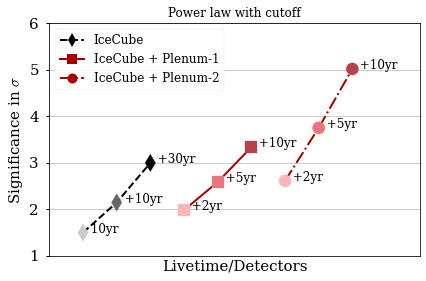

In [92]:
### plot significance vs livetime/detector configs
f, ax = plt.subplots(figsize=(6, 4))
label_size = 12
# ICECUBE
ax.plot(
    pval_df.loc[[0, 1, 2]]["identifier"], 
    pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"],
    ls=contour_formats["IceCube"]["linestyles"], color=poles["IceCube"]["color"],
    marker="d", label="IceCube", ms=10
)
ax.scatter(
    x=pval_df.loc[[0, 1, 2]]["identifier"], 
    y=pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"], 
    c=many_colors[:3], s=150, zorder=10, marker="d"
)
ax.text(
    x=pval_df.loc[0]["identifier"], 
    y=pval_df.loc[0][r"Significance in $\sigma$"],
    s="  10yr", fontsize=label_size
)
ax.text(
    x=pval_df.loc[1]["identifier"], 
    y=pval_df.loc[1][r"Significance in $\sigma$"],
    s="  +10yr", fontsize=label_size
)
ax.text(
    x=pval_df.loc[2]["identifier"], 
    y=pval_df.loc[2][r"Significance in $\sigma$"],
    s="  +30yr", fontsize=label_size
)

## PLENUM-1
ax.plot(
    pval_df.loc[[3, 4, 5]]["identifier"], 
    pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"],
    ls=poles["Plenum-1"]["ls"], color=poles["Plenum-1"]["color"],
    marker="s", label="IceCube + Plenum-1", ms=10
)
ax.scatter(
    x=pval_df.loc[[3, 4, 5]]["identifier"], 
    y=pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"], 
    c=many_colors[3:6], s=150, zorder=10, marker="s"
)
ax.text(
    x=pval_df.loc[3]["identifier"], 
    y=pval_df.loc[3][r"Significance in $\sigma$"],
    s="  +2yr", fontsize=label_size
)
ax.text(
    x=pval_df.loc[4]["identifier"], 
    y=pval_df.loc[4][r"Significance in $\sigma$"],
    s="  +5yr", fontsize=label_size
)
ax.text(
    x=pval_df.loc[5]["identifier"], 
    y=pval_df.loc[5][r"Significance in $\sigma$"],
    s="  +10yr", fontsize=label_size
)


## PLENUM-2
ax.plot(
    pval_df.loc[[6, 7, 8]]["identifier"], 
    pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"],
    ls=poles["Plenum-2"]["ls"], color=poles["Plenum-2"]["color"],
    marker="o", label="IceCube + Plenum-2", ms=10
)
ax.scatter(
    x=pval_df.loc[[6, 7, 8]]["identifier"], 
    y=pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"], 
    c=many_colors[3:6], s=150, zorder=10, marker="o"
)
ax.text(
    x=pval_df.loc[6]["identifier"], 
    y=pval_df.loc[6][r"Significance in $\sigma$"],
    s="  +2yr", fontsize=label_size
)
ax.text(
    x=pval_df.loc[7]["identifier"], 
    y=pval_df.loc[7][r"Significance in $\sigma$"],
    s="  +5yr", fontsize=label_size
)
ax.text(
    x=pval_df.loc[8]["identifier"], 
    y=pval_df.loc[8][r"Significance in $\sigma$"],
    s="  +10yr", fontsize=label_size
)

ax.set_xlim(-1, 10)
ax.set_ylim(1, 6)
ax.set_xticks([])
ax.legend(fontsize=label_size)
ax.set_title("Power law with cutoff", fontsize=label_size)
ax.set_xlabel("Livetime/Detectors")
ax.set_ylabel(r"Significance in $\sigma$")
plt.tight_layout()
plt.savefig("../plots/cutoff_sigma_vs_det_talk.pdf")

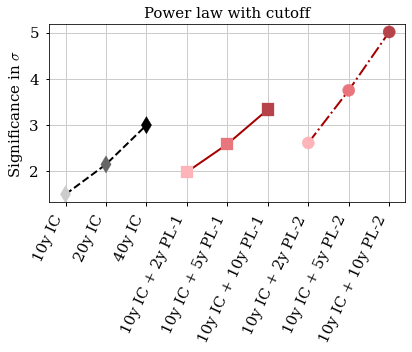

In [94]:
# same plot, alternative labeling as in PoS(ICRC2021)1185 
f, ax = plt.subplots(figsize=(6, 5))

ax.plot(
    pval_df.loc[[0, 1, 2]]["identifier"], 
    pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"],
    ls=contour_formats["IceCube"]["linestyles"], color=poles["IceCube"]["color"]
)
ax.scatter(
    x=pval_df.loc[[0, 1, 2]]["identifier"], 
    y=pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"], 
    c=many_colors[:3], s=150, zorder=10, marker="d"
)

ax.plot(
    pval_df.loc[[3, 4, 5]]["identifier"], 
    pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"],
    ls=poles["Plenum-1"]["ls"], color=poles["Plenum-1"]["color"]
)
ax.scatter(
    x=pval_df.loc[[3, 4, 5]]["identifier"], 
    y=pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"], 
    c=many_colors[3:6], s=150, zorder=10, marker="s"
)

ax.plot(
    pval_df.loc[[6, 7, 8]]["identifier"], 
    pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"],
    ls=poles["Plenum-2"]["ls"], color=poles["Plenum-2"]["color"]
)
ax.scatter(
    x=pval_df.loc[[6, 7, 8]]["identifier"], 
    y=pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"], 
    c=many_colors[3:6], s=150, zorder=10, marker="o"
)


#ax.set_ylim(0, 5.5)
ax.set_title("Power law with cutoff")
ax.set_xlabel("")
ax.set_ylabel(r"Significance in $\sigma$")
plt.xticks(rotation=65, fontsize=15, ha="right")
plt.tight_layout()
plt.savefig("../plots/cutoff_sigma_vs_det.pdf")

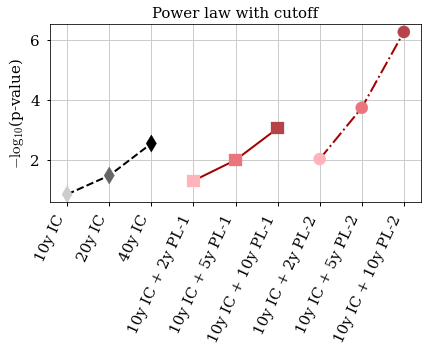

In [95]:
f, ax = plt.subplots(figsize=(6, 5))
ax.plot(
    pval_df.loc[[0, 1, 2]]["identifier"], 
    pval_df.loc[[0, 1, 2]][r"$-\log_{10}$(p-value)"],
    ls=contour_formats["IceCube"]["linestyles"], color=poles["IceCube"]["color"]
)
ax.scatter(
    x=pval_df.loc[[0, 1, 2]]["identifier"], 
    y=pval_df.loc[[0, 1, 2]][r"$-\log_{10}$(p-value)"], 
    c=many_colors[:3], s=150, zorder=10, marker="d"
)

ax.plot(
    pval_df.loc[[3, 4, 5]]["identifier"], 
    pval_df.loc[[3, 4, 5]][r"$-\log_{10}$(p-value)"],
    ls=poles["Plenum-1"]["ls"], color=poles["Plenum-1"]["color"]
)
ax.scatter(
    x=pval_df.loc[[3, 4, 5]]["identifier"], 
    y=pval_df.loc[[3, 4, 5]][r"$-\log_{10}$(p-value)"], 
    c=many_colors[3:6], s=150, zorder=10, marker="s"
)

ax.plot(
    pval_df.loc[[6, 7, 8]]["identifier"], 
    pval_df.loc[[6, 7, 8]][r"$-\log_{10}$(p-value)"],
    ls=poles["Plenum-2"]["ls"], color=poles["Plenum-2"]["color"]
)
ax.scatter(
    x=pval_df.loc[[6, 7, 8]]["identifier"], 
    y=pval_df.loc[[6, 7, 8]][r"$-\log_{10}$(p-value)"], 
    c=many_colors[3:6], s=150, zorder=10, marker="o"
)

ax.set_title("Power law with cutoff")
ax.set_xlabel("")
ax.set_ylabel(r"$-\log_{10}$(p-value)")
plt.xticks(rotation=65, fontsize=15, ha="right")
plt.tight_layout()
plt.savefig("../plots/cutoff_pval_vs_det.pdf")

## Significance vs cutoff value

In [96]:
print_names = {
    "IceCube": "IceCube",
    "Plenum-1": r"IceCube + PLE$\nu$M-1",
    "Plenum-2": r"IceCube + PLE$\nu$M-2"
}

In [97]:
pvals = []
cutoff_vals = np.round(np.arange(5.0, 8.1, step=0.2), 1)
for e_cut in cutoff_vals:
    for li, ident in enumerate(idents):
        shape = "powerlaw with cutoff"
        aeff_factor = aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
        if "Plenum" in ident:
            aeff_factor += aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width) * LIVETIME
        # asimov = expectation of perfect experiment
        shp_params = np.copy(shape_params[shape]["baseline"])
        shp_params[-1] = e_cut
        k_i = asimov_data(
            aeff_factor, shape, verbose=False, shp_params=shp_params)

        # global min
        out = fmin_l_bfgs_b(
            spectral_ts_func,
            x0=shape_params[shape]["guess"],
            bounds=shape_params[shape]["bounds"],
            approx_grad=True,
            args=(aeff_factor, emids, E_NORM, k_i, shape)
        )
        # check that the TS at the fit minimum is close to the TS of the baseline params
        reference = spectral_ts_func(
            shp_params,
            aeff_factor, emids, E_NORM, k_i, shape
        )
        baseline_ts_check = np.isclose(out[1], reference, rtol=1E-2)
        if not baseline_ts_check:
            print("TS asimov check:", "not OK :(")
        if not baseline_ts_check:
            print("e_cut:", shp_params[-1])
            print("fit: ", out[1], ", reference:", reference)
        # best fit powerlaw as null hypothesis     
        out_pl = fmin_l_bfgs_b(
            spectral_ts_func,
            x0=shape_params["powerlaw"]["guess"],
            bounds=shape_params["powerlaw"]["bounds"],
            approx_grad=True,
            args=(aeff_factor, emids, E_NORM, k_i, "powerlaw")
        )
        pval = chi2.sf(out_pl[1] - out[1], 1)
        significance = erfinv(1 - pval) * np.sqrt(2)
        # print("P-VALUE:", pval, ", SIGNIFICANCE:", significance)
        pvals.append({"ident": print_names[ident], "pval": pval, 
                      r"Significance in $\sigma$": significance, 
                      r"$\log_{10}(E_{\rm cut}/{\rm GeV})$": e_cut,
                      r"Conv_PL": out_pl[0][0],
                      r"$\gamma_{PL}$": out_pl[0][1],
                      r"$\Phi_{0,PL}$": out_pl[0][2],
                      r"Conv": out[0][0],
                      r"$\gamma$": out[0][1],
                      r"$\Phi_{0}$": out[0][2],
                      r"$E_{\rm cut}$": out[0][3]
                     })

pval_df = pd.DataFrame(pvals)
pval_df[r"$-\log_{10}$(p-value)"] = -np.log10(pval_df.pval)

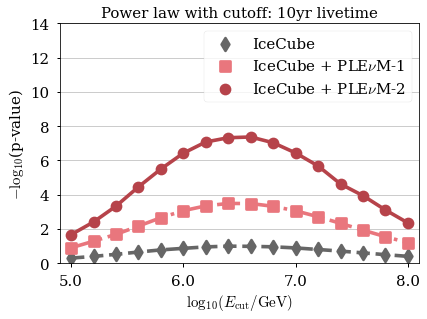

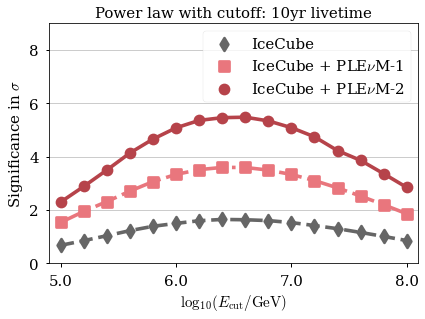

In [98]:
f, ax = plt.subplots(figsize=(6, 4.5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"$-\log_{10}$(p-value)", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$", 
    palette=many_colors[[1, 4, 5]], linestyles=["--", "-.", "-"], markers=["d", "s", "o"]
)
ax.set_title("Power law with cutoff: 10yr livetime")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1) #, fontsize="x-small")
ax.set_ylim(0, 14)
plt.tight_layout()
plt.savefig("../plots/cutoff_pval_vs_cutoff.pdf")

f, ax = plt.subplots(figsize=(6, 4.5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"Significance in $\sigma$", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$", 
    palette=many_colors[[1, 4, 5]], linestyles=["--", "-.", "-"], markers=["d", "s", "o"]
)
ax.set_title("Power law with cutoff: 10yr livetime")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1) #, fontsize="x-small")
ax.set_ylim(0, 9)
f.tight_layout()
plt.savefig("../plots/cutoff_sigma_vs_cutoff.pdf")

## check that parameter fits are ok

In [92]:
plot_kw = dict(
    palette=many_colors[[1, 4, 5]],
    linestyles=["-", "-.", "-"],
    markers=["d", "s", "o"],
)

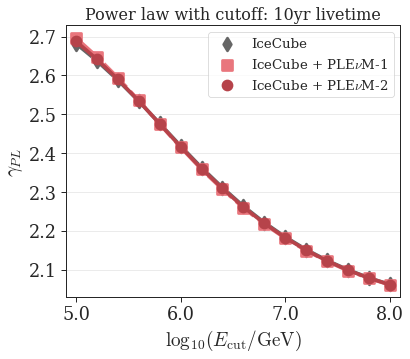

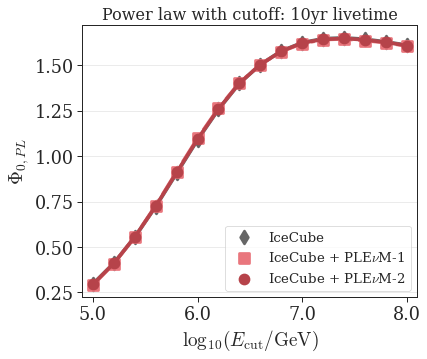

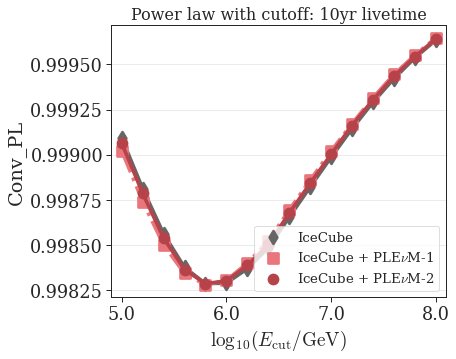

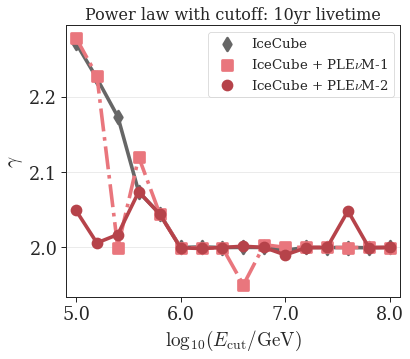

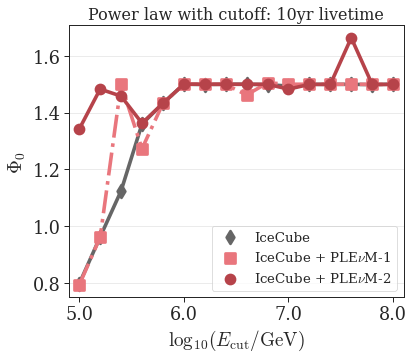

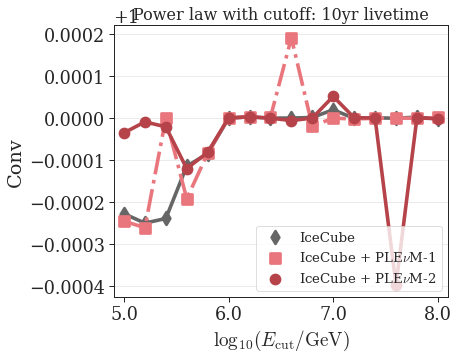

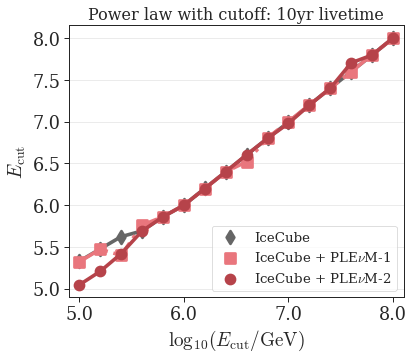

In [93]:
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"$\gamma_{PL}$", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$", 
    **plot_kw
    
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"$\Phi_{0,PL}$", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$", 
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"Conv_PL", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$", 
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"$\gamma$", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$", 
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"$\Phi_{0}$", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$", 
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"Conv", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$", 
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"$E_{\rm cut}$", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$", 
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")